In [123]:
import json
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Union, Tuple, Dict
import re

In [124]:
%config InlineBackend.figure_format = 'retina'

# Plotting Routine

This code snippet was used to generate all plots in the paper. The input for plotting is the JSON file output by `run_expr.py` and then optionally combined using `combine_results.py`. 

In [4]:
with open('') as f:
    statistics = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: ''

In [126]:
statistics.keys()

dict_keys(['ScanBestOrder', 'ScanWorstOrder', 'SortedIndexScan', 'EpsGreedy', 'UniformExploration', 'UniformSample', 'UCB', 'EpsGreedy (F=5%)', 'EpsGreedy (F=10%)', 'EpsGreedy (F=25%)', 'EpsGreedy (No Rebinning)', 'EpsGreedy (No Subtraction)', 'EpsGreedy (No Fallback)', 'EpsGreedy (Batch=100)', 'EpsGreedy (Batch=200)', 'EpsGreedy (Batch=800)'])

In [127]:
def plot_metric_per_time_or_iter(result_stats: Dict, 
                                 order: Union[str, List[str], None], 
                                 metric: str, 
                                 x_axis: str, 
                                 y_log: bool = False, 
                                 x_log: bool = False, 
                                 ylabel: Union[None, str] = None, 
                                 xlabel: Union[None, str] = None, 
                                 title: Union[None, str] = None, 
                                 filename: Union[None, str] = None, 
                                 xrange: Union[None, Tuple[float, float]] = None, 
                                 yrange: Union[None, Tuple[float, float]] = None, 
                                 linewidth: float = 1,
                                 place_legend_outside: bool = False,
                                 legend_loc: str = "best",
                                 fontsize: float = 16):
    """
    Plots specified metric(s) over time or iterations given result statistics. 
    
    Parameters
    result_stats: A dictionary mapping from config name to the result statistics for the config. 
    metric: The metric to use for the y-axis. One of 'STK', 'KLS', 'Precision@K', 'Recall@K', 'AvgRank' or 'WorstRank'. 
    x_axis: The metric to use for the x-axis. Either 'sec', 'hour', or 'iteration'. 
    y_log: Whether the y-axis should be logarithmically scaled. 
    x_log: Whether the x-axis should be logarithmically scaled. 
    ylabel: The label for the y-axis. 
    xlabel: The label for the x-axis. 
    title: The title of the plot. 
    filename: The file that this plot should be saved to. 
    xrange: The range to limit the x-axis to. 
    yrange: The range to limit the y-axis to. 
    linewidth: The width of the lines in the plot. 
    """
    plt.figure(figsize=(16, 10))

    if order is None:
        order = global_order
    if isinstance(order, str):
        order = method_collections[order]

    # Plot each config specified in order
    for config_name in order:
        # Obtain the stats for this config
        if config_name in result_stats and config_name in methods:
            stats: Dict = result_stats[config_name]
            
            # Obtain the x values
            if x_axis == 'sec' or x_axis == 'hour':
                x_values: List[float] = stats['time']
                if x_axis == 'hour':  # The 'time' field logs time incurred in seconds
                    x_values = np.array(x_values) / 3600.0
            elif x_axis == 'iteration':
                x_values = list(range(1, len(stats[f'{metric}'])+1))
            else:
                raise ValueError

            # Obtain the y values
            y_values = [stats[f'{metric}'][i] for i in range(0, len(stats[f'{metric}']))]

            # Create plot
            plt.plot(x_values, y_values, 
                     label=methods[config_name]['name'], 
                     color=methods[config_name]['color'], 
                     linestyle=methods[config_name]['style'], 
                     linewidth=linewidth)

    # Label the x-axis
    if x_axis == 'sec':
        xlabel = 'Time (s)'
    elif x_axis == 'hour':
        xlabel = 'Time (hr)'
    elif x_axis == 'iteration':
        xlabel = 'Iteration'
    else:
        raise ValueError
    plt.xlabel(xlabel, fontsize=fontsize)

    # Label the y-axis
    if not ylabel:
        plt.ylabel(f'{metric} Value', fontsize=fontsize)
    else:
        plt.ylabel(ylabel, fontsize=fontsize)

    # Limit axis values optionally
    if xrange is not None:
        plt.xlim(xrange)
    if yrange is not None:
        plt.ylim(yrange)

    # Title, legend, grid
    if title is not None:
        plt.title(title)
    if place_legend_outside:
        plt.legend(loc=legend_loc, fontsize=fontsize, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    else:
        plt.legend(loc=legend_loc, fontsize=14)
    plt.grid(visible=True, color="#f0f0f0")

    # Log scale the axis optionally
    if y_log:
        plt.yscale('log')
    if x_log:
        plt.xscale('log')

    # Save plot to file optionally
    if filename is not None:
        plt.savefig(filename, format="pdf", bbox_inches="tight")
    
    plt.show()

In [128]:
# Conversion factors for time units
time_units = {
    "s": 1,
    "ms": 1e3,
    "μs": 1e6,
    "ns": 1e9,
    "hr": 1 / 3600
}

In [129]:
# A pre-set collection of method names for different types
method_collections = {
    "scan":
    [
        "ScanBestOrder", "ScanWorstOrder"
    ],
    "all": 
    [
        "ScanBestOrder", "ScanWorstOrder", 
        "SortedIndexScan", "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
        "EpsGreedy (No Rebinning)", "EpsGreedy (No Subtraction)", "EpsGreedy (No Fallback)",
        "EpsGreedy (B=4)", "EpsGreedy (B=16)", "EpsGreedy (B=32)",
        "EpsGreedy (F=5%)", "EpsGreedy (F=10%)", "EpsGreedy (F=25%)", "EpsGreedy (25%)",
        "EpsGreedy (Batch=25)", "EpsGreedy (Batch=50)", "EpsGreedy (Batch=100)", "EpsGreedy (Batch=200)", "EpsGreedy (Batch=400)", "EpsGreedy (Batch=800)"
    ],
    "all except scan":
    [
        "SortedIndexScan", "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
        "EpsGreedy (No Rebinning)", "EpsGreedy (No Subtraction)", "EpsGreedy (No Fallback)",
        "EpsGreedy (B=4)", "EpsGreedy (B=16)", "EpsGreedy (B=32)",
        "EpsGreedy (F=0.1%)", "EpsGreedy (F=10%)", "EpsGreedy (F=25%)"
    ],
    "main six":
    [
        "ScanBestOrder", "ScanWorstOrder", "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
    ],
    "main five":
    [
        "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
    ],
    "main five plus scan":
    [
        "ScanBestOrder", "ScanWorstOrder",
        "SortedIndexScan", "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
    ],
    "ablation":
    [
        "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
        "EpsGreedy (No Rebinning)", "EpsGreedy (No Subtraction)", "EpsGreedy (No Fallback)"
    ],
    "parameters":
    [
        "SortedIndexScan", "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
        "EpsGreedy (B=4)", "EpsGreedy (B=16)", "EpsGreedy (B=32)",
        "EpsGreedy (F=5%)", "EpsGreedy (F=10%)", "EpsGreedy (25%)"
    ],
    "batch":
    [
        "SortedIndexScan", "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
        "EpsGreedy (B=4)", "EpsGreedy (B=16)", "EpsGreedy (B=32)"
    ],
    "frequency":
    [
        "EpsGreedy", "EpsGreedy (F=5%)", "EpsGreedy (F=10%)", "EpsGreedy (25%)"
    ],
    "ablation-and-frequency":
    [
        "SortedIndexScan", "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
        "EpsGreedy (No Rebinning)", "EpsGreedy (No Subtraction)", "EpsGreedy (No Fallback)",
        "EpsGreedy (F=5%)", "EpsGreedy (F=10%)", "EpsGreedy (25%)"
    ],
    "parameters-subset":
    [
        "EpsGreedy", "UniformExploration",
        "EpsGreedy (B=4)", "EpsGreedy (B=16)", "EpsGreedy (B=32)",
        "EpsGreedy (F=5%)", "EpsGreedy (F=10%)", "EpsGreedy (25%)"
    ],
    "batchsize":
    [
        "SortedIndexScan", "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
        "EpsGreedy (Batch=25)", "EpsGreedy (Batch=50)", "EpsGreedy (Batch=100)", "EpsGreedy (Batch=200)", "EpsGreedy (Batch=800)"
    ],
    "params2":
    [
        "SortedIndexScan", "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
        "EpsGreedy (B=4)", "EpsGreedy (B=16)", "EpsGreedy (B=32)",
        "EpsGreedy (F=5%)", "EpsGreedy (F=10%)", "EpsGreedy (F=25%)",
        "EpsGreedy (Batch=25)", "EpsGreedy (Batch=50)", "EpsGreedy (Batch=100)", "EpsGreedy (Batch=200)", "EpsGreedy (Batch=800)"
    ],
    "batch-and-ablation":
    [
        "SortedIndexScan", "EpsGreedy", "UCB", "UniformExploration", "UniformSample",
        "EpsGreedy (Batch=25)", "EpsGreedy (Batch=50)", "EpsGreedy (Batch=100)", "EpsGreedy (Batch=200)", "EpsGreedy (Batch=800)"
    ],
    "frequency-and-batch":
    [
        "EpsGreedy", "EpsGreedy (F=5%)", "EpsGreedy (F=10%)", "EpsGreedy (F=25%)", 
        "EpsGreedy (Batch=25)", "EpsGreedy (Batch=50)", "EpsGreedy (Batch=100)", "EpsGreedy (Batch=200)", "EpsGreedy (Batch=800)"
    ]
}

In [130]:
global_order = "all"

In [131]:
# A mapping from method name to its label, color, and line-style. 
# These mappings are kept consistent across experiments by setting this as a global variable. 
methods = {
    "ScanBestOrder": {  
        "name": "Scan (Best Case)",
        "color": "#BBBBBB",  # black
        "style": "solid",
        "index": None
    },
    "ScanWorstOrder": {  
        "name": "Scan (Worst Case)",
        "color": "#000000",  # white
        "style": "solid",
        "index": None
    },
    "UniformSample": {  
        "name": "UniformSample",
        "color": "#EE3377",  # magenta
        "style": "solid",
        "index": None
    },
    "SortedIndexScan": {  
        "name": "SortedIndexScan",
        "color": "#8c3756",  # orange
        "style": "solid",
        "index": "sorted"
    },
    "UCB": {  
        "name": "UCB",
        "color": "#EE7733",  # magenta
        "style": "solid",
        "index": "dendrogram"
    },
    "UniformExploration": {  
        "name": "ExplorationOnly",
        "color": "#CC3311",  # red
        "style": "solid",
        "index": "dendrogram"
    },
    "EpsGreedy": {
        "name": "Ours",
        "color": "#0077BB",  # blue
        "style": "solid",
        "index": "dendrogram"
    },
    "EpsGreedy (No Rebinning)": {
        "name": "Ours (No Re-binning)",
        "color": "#332288",  # indigo
        "style": "dashed",
        "index": "dendrogram"
    },
    "EpsGreedy (No Subtraction)": {
        "name": "Ours (No Subtraction)",
        "color": "#8877EE",  # cyan
        "style": "dashed",
        "index": "dendrogram"
    },
    "EpsGreedy (No Fallback)": {
        "name": "Ours (No Fallback)",
        "color": "#44AA99",  # teal
        "style": "dashed",
        "index": "dendrogram"
    },
    "EpsGreedy (B=4)": {
        "name": "Ours (B=4)",
        "color": "#FEDA8B", # yellow
        "style": "dotted",
        "index": "dendrogram"
    },
    "EpsGreedy (B=16)": {
        "name": "Ours (B=16)",
        "color": "#FDB366",  # orange
        "style": "dotted",
        "index": "dendrogram"
    },
    "EpsGreedy (B=32)": {
        "name": "Ours (B=32)",
        "color": "#F67E4B",  # dark orange
        "style": "dotted",
        "index": "dendrogram"
    },
    "EpsGreedy (F=5%)": {
        "name": "F=0.05",
        "color": "#E7D4E8",  # light purple
        "style": "dashdot",
        "index": "dendrogram"
    },
    "EpsGreedy (F=10%)": {
        "name": "F=0.1",
        "color": "#C2A5CF",  # purple
        "style": "dashdot",
        "index": "dendrogram"
    },
    "EpsGreedy (F=25%)": {
        "name": "F=0.25",
        "color": "#9970AB",  # dark purple
        "style": "dashdot",
        "index": "dendrogram"
    },
    "EpsGreedy (25%)": {
        "name": "F=0.25",
        "color": "#9970AB",  # dark purple
        "style": "dashdot",
        "index": "dendrogram"
    },
    "EpsGreedy (Batch=25)": {
        "name": "Batch=25",
        "color": "#364B94",  
        "style": "dotted",
        "index": "dendrogram"
    },
    "EpsGreedy (Batch=50)": {
        "name": "Batch=50",
        "color": "#4A7BB7",  
        "style": "dotted",
        "index": "dendrogram"
    },
    "EpsGreedy (Batch=100)": {
        "name": "Batch=100",
        "color": "#6EA6CD",  
        "style": "dotted",
        "index": "dendrogram"
    },
    "EpsGreedy (Batch=200)": {
        "name": "Batch=200",
        "color": "#98CAE1",  
        "style": "dotted",
        "index": "dendrogram"
    },
    "EpsGreedy (Batch=800)": {
        "name": "Batch=800",
        "color": "#022963",  
        "style": "dotted",
        "index": "dendrogram"
    }
}

## Curve Plots

Six plots (STK vs iter, STK/KLS/Precision@K/Recall@K/AvgRank/WorstRank vs time) have been pre-defined. 

For different datasets, you may need to modify:
1. The methods included in "order".
2. Name of the saved file.
3. Line width for readability.
4. Whether x-axis (time) is "sec" or "hour". 

Note that the `ScanBestOrder` and `ScanWorstOrder` configs have the "time" field, but this is not comparable to other methods since the "time" field for the GT run does not include the priority queue maintenance overhead. Hence, in the paper, `ScanBestOrder` and `ScanWorstOrder` are included only for Figure 4, Synthetic data. 

### STK vs Iteration

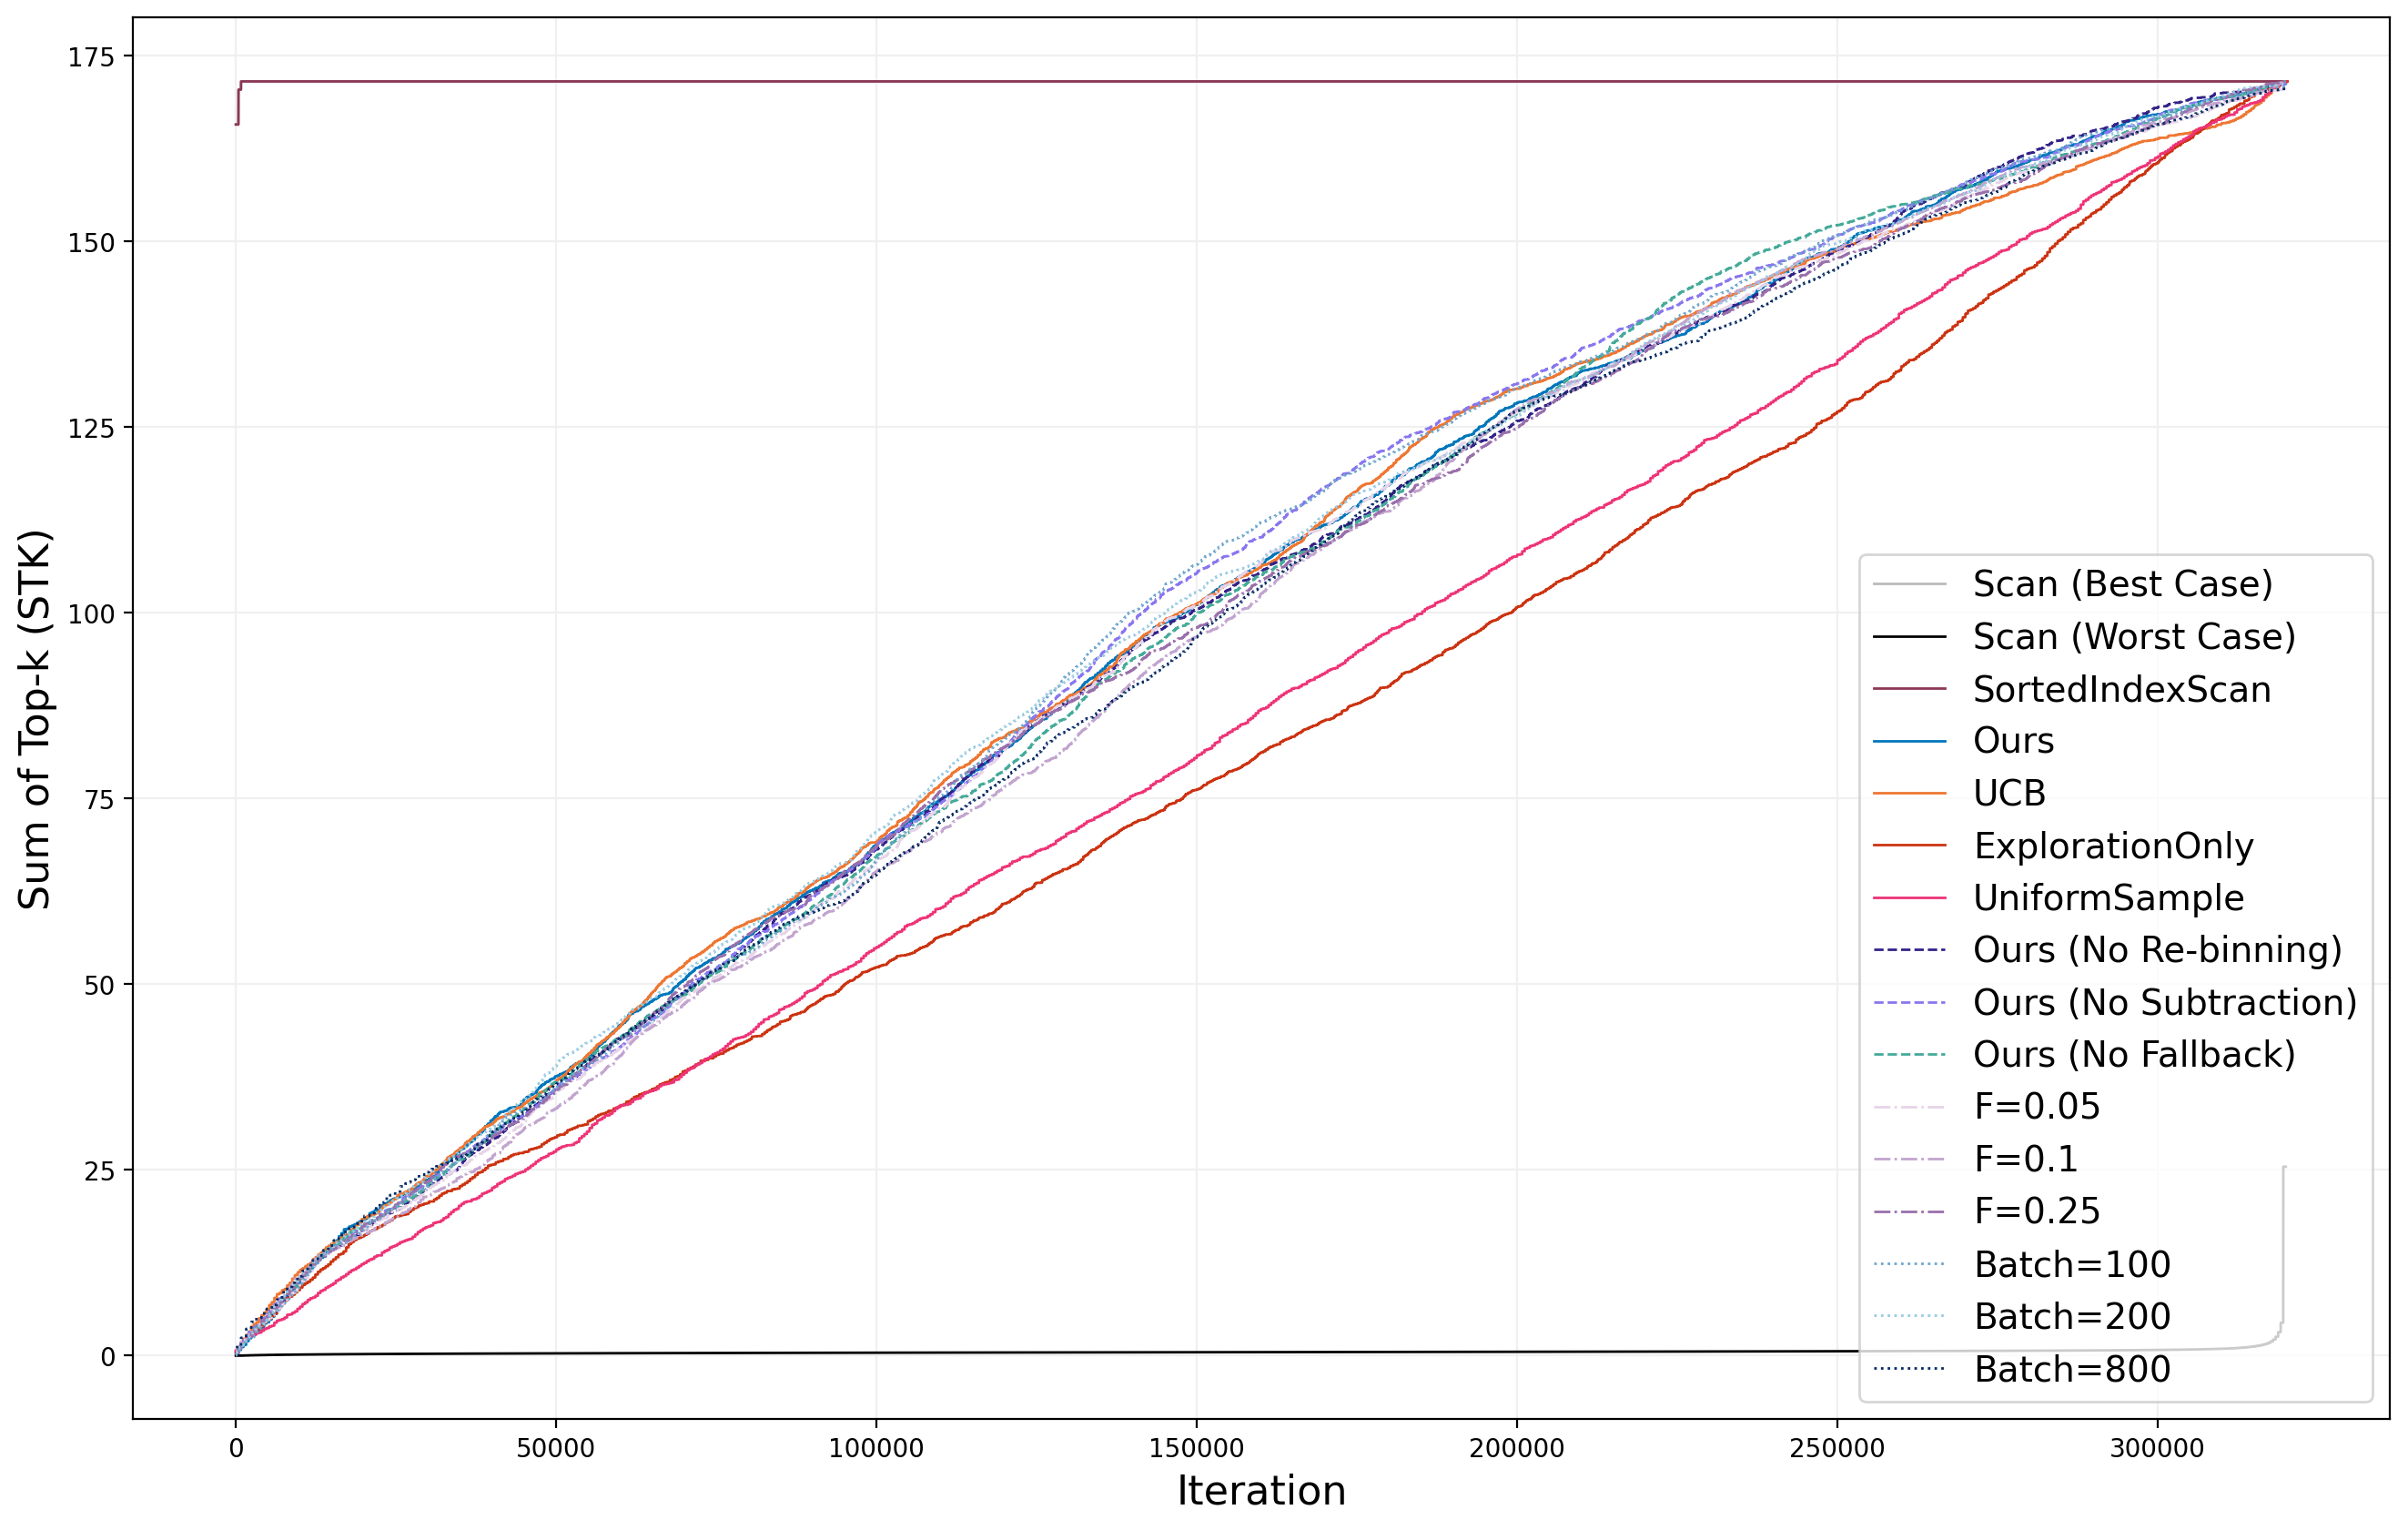

In [132]:
plot_metric_per_time_or_iter(statistics, 
                             order=None,
                             metric='STK',
                             x_axis='iteration',
                             title=None, 
                             filename=None, 
                             ylabel="Sum of Top-k (STK)", 
                             xlabel=None,
                             xrange=None,
                             yrange=None,
                             x_log=False,
                             linewidth=1,
                             legend_loc='lower right')

### STK vs Time

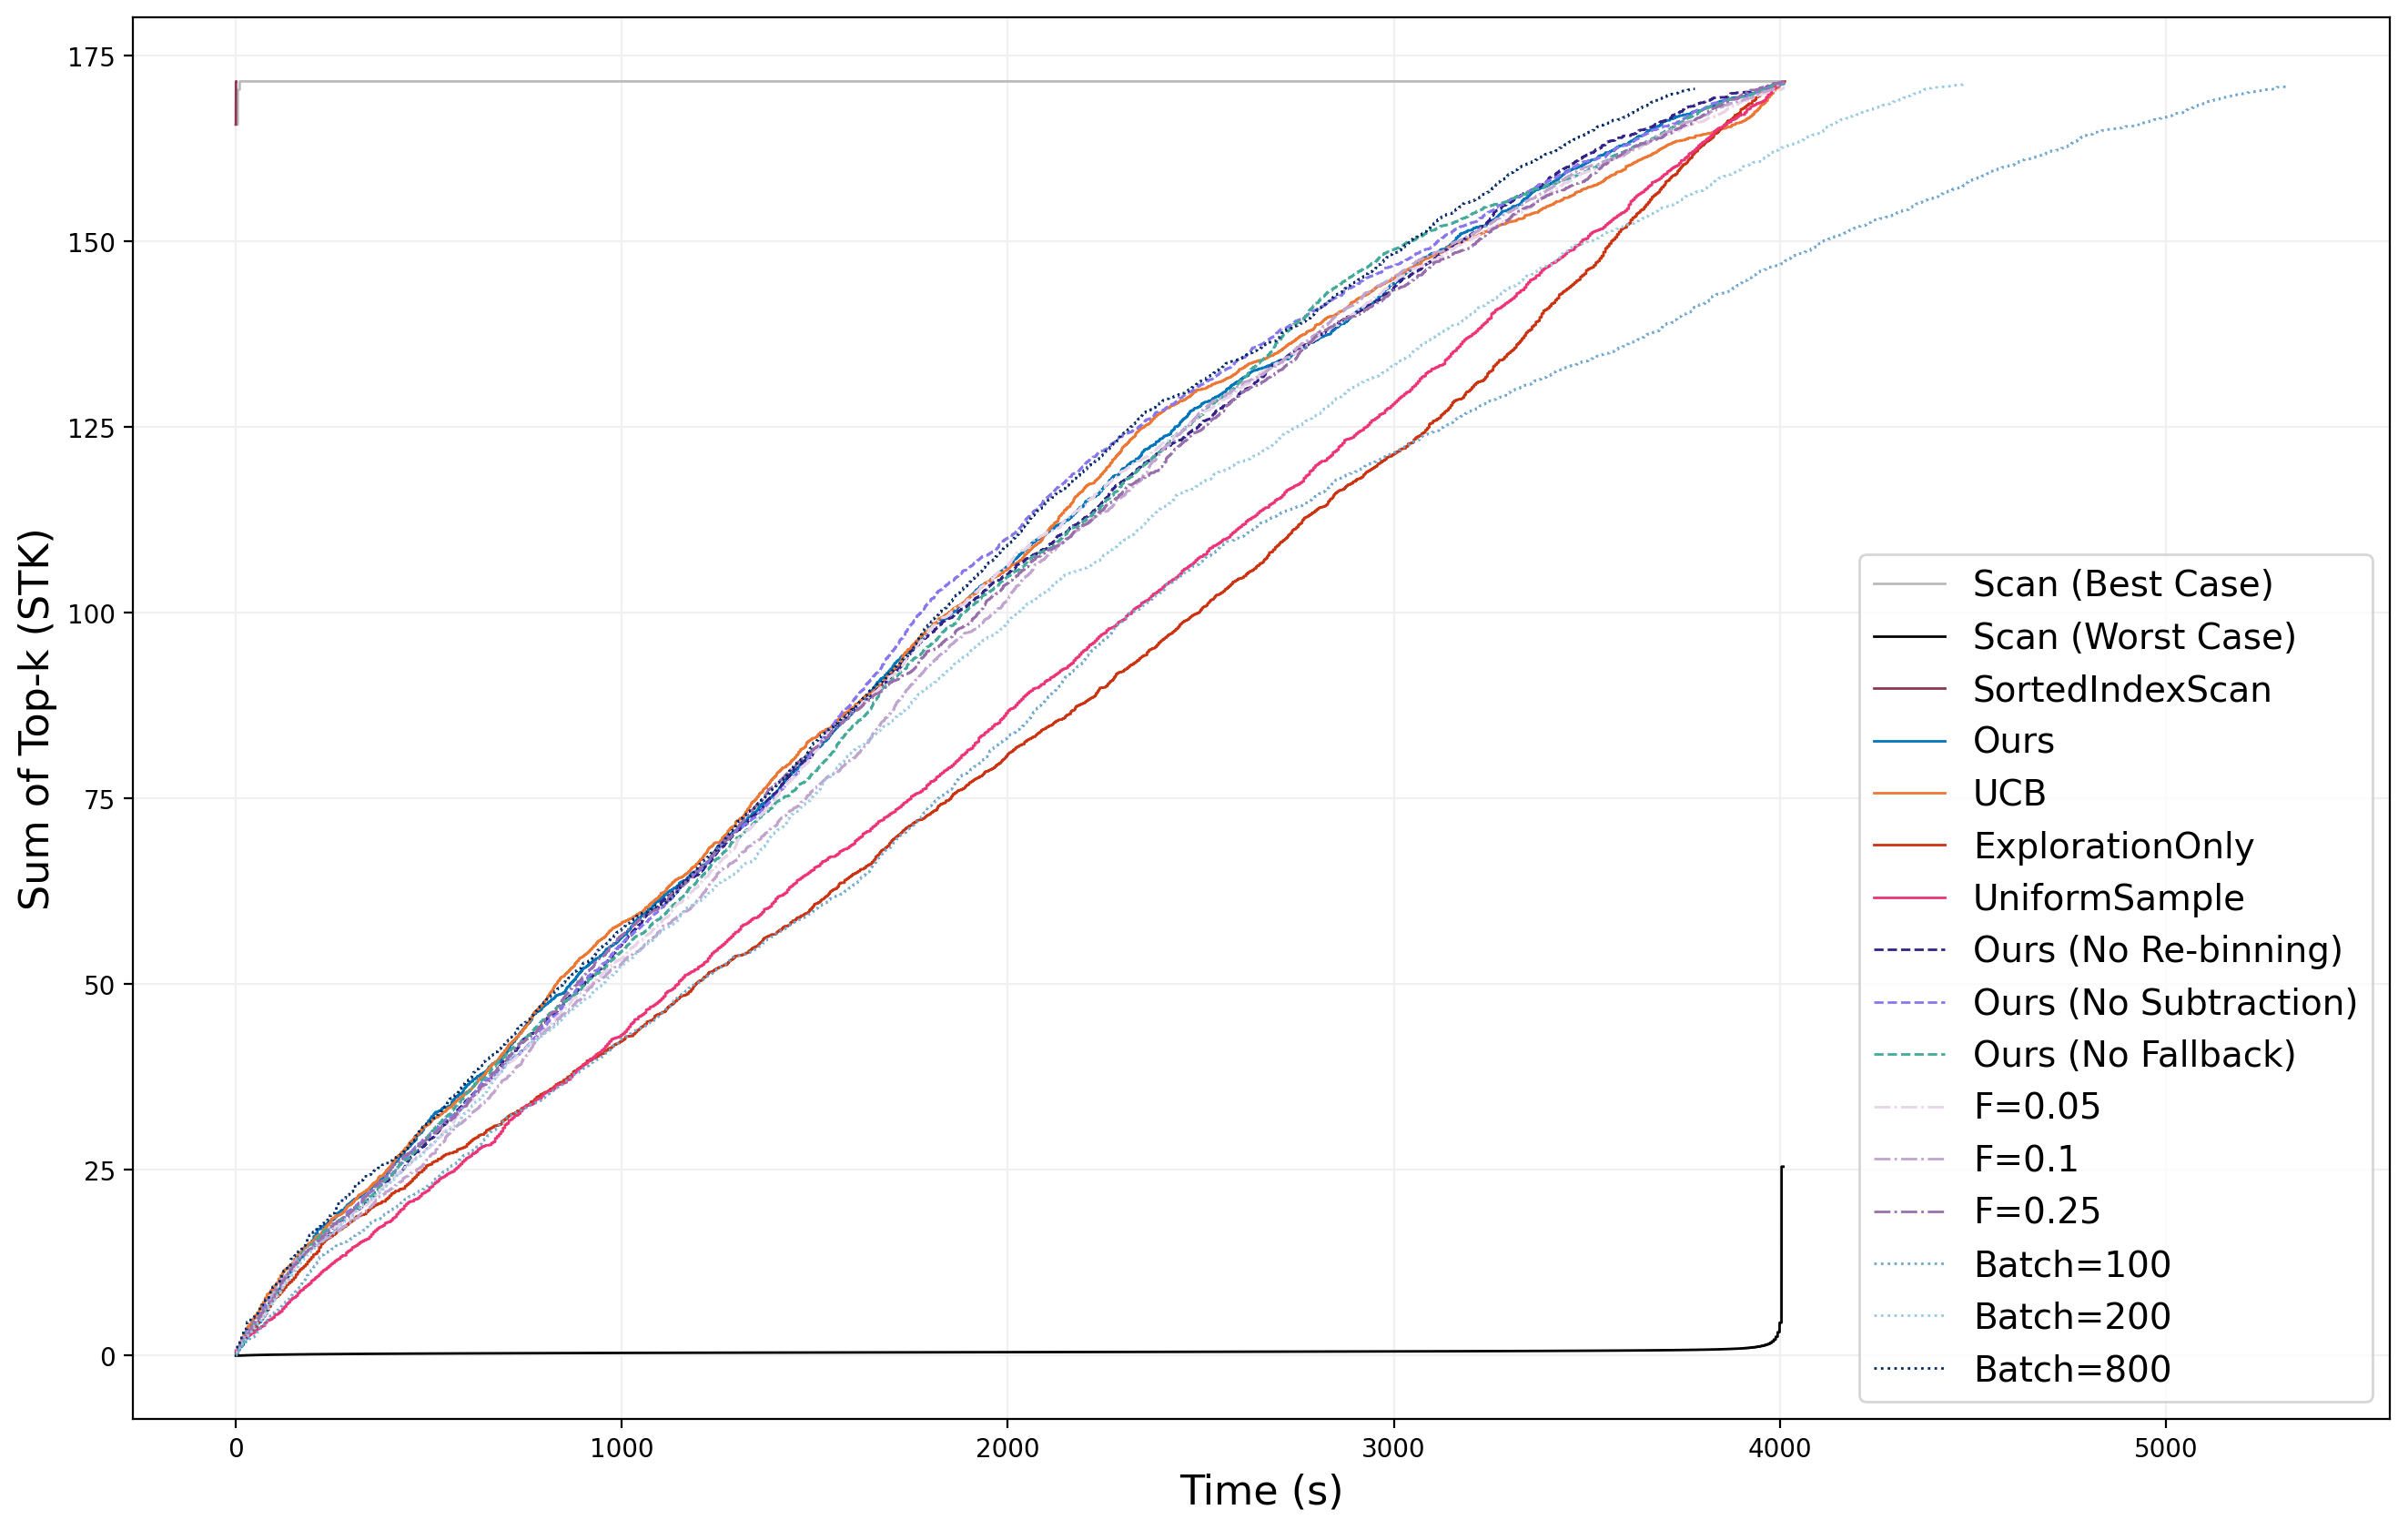

In [133]:
plot_metric_per_time_or_iter(statistics, 
                             order=None,
                             metric='STK',
                             x_axis='sec',
                             title=None, 
                             filename=None, 
                             ylabel="Sum of Top-k (STK)", 
                             xlabel=None,
                             xrange=None,
                             x_log=False,
                             y_log=False,
                             yrange=None,
                             linewidth=1,
                             legend_loc='best')

### KLS vs Time

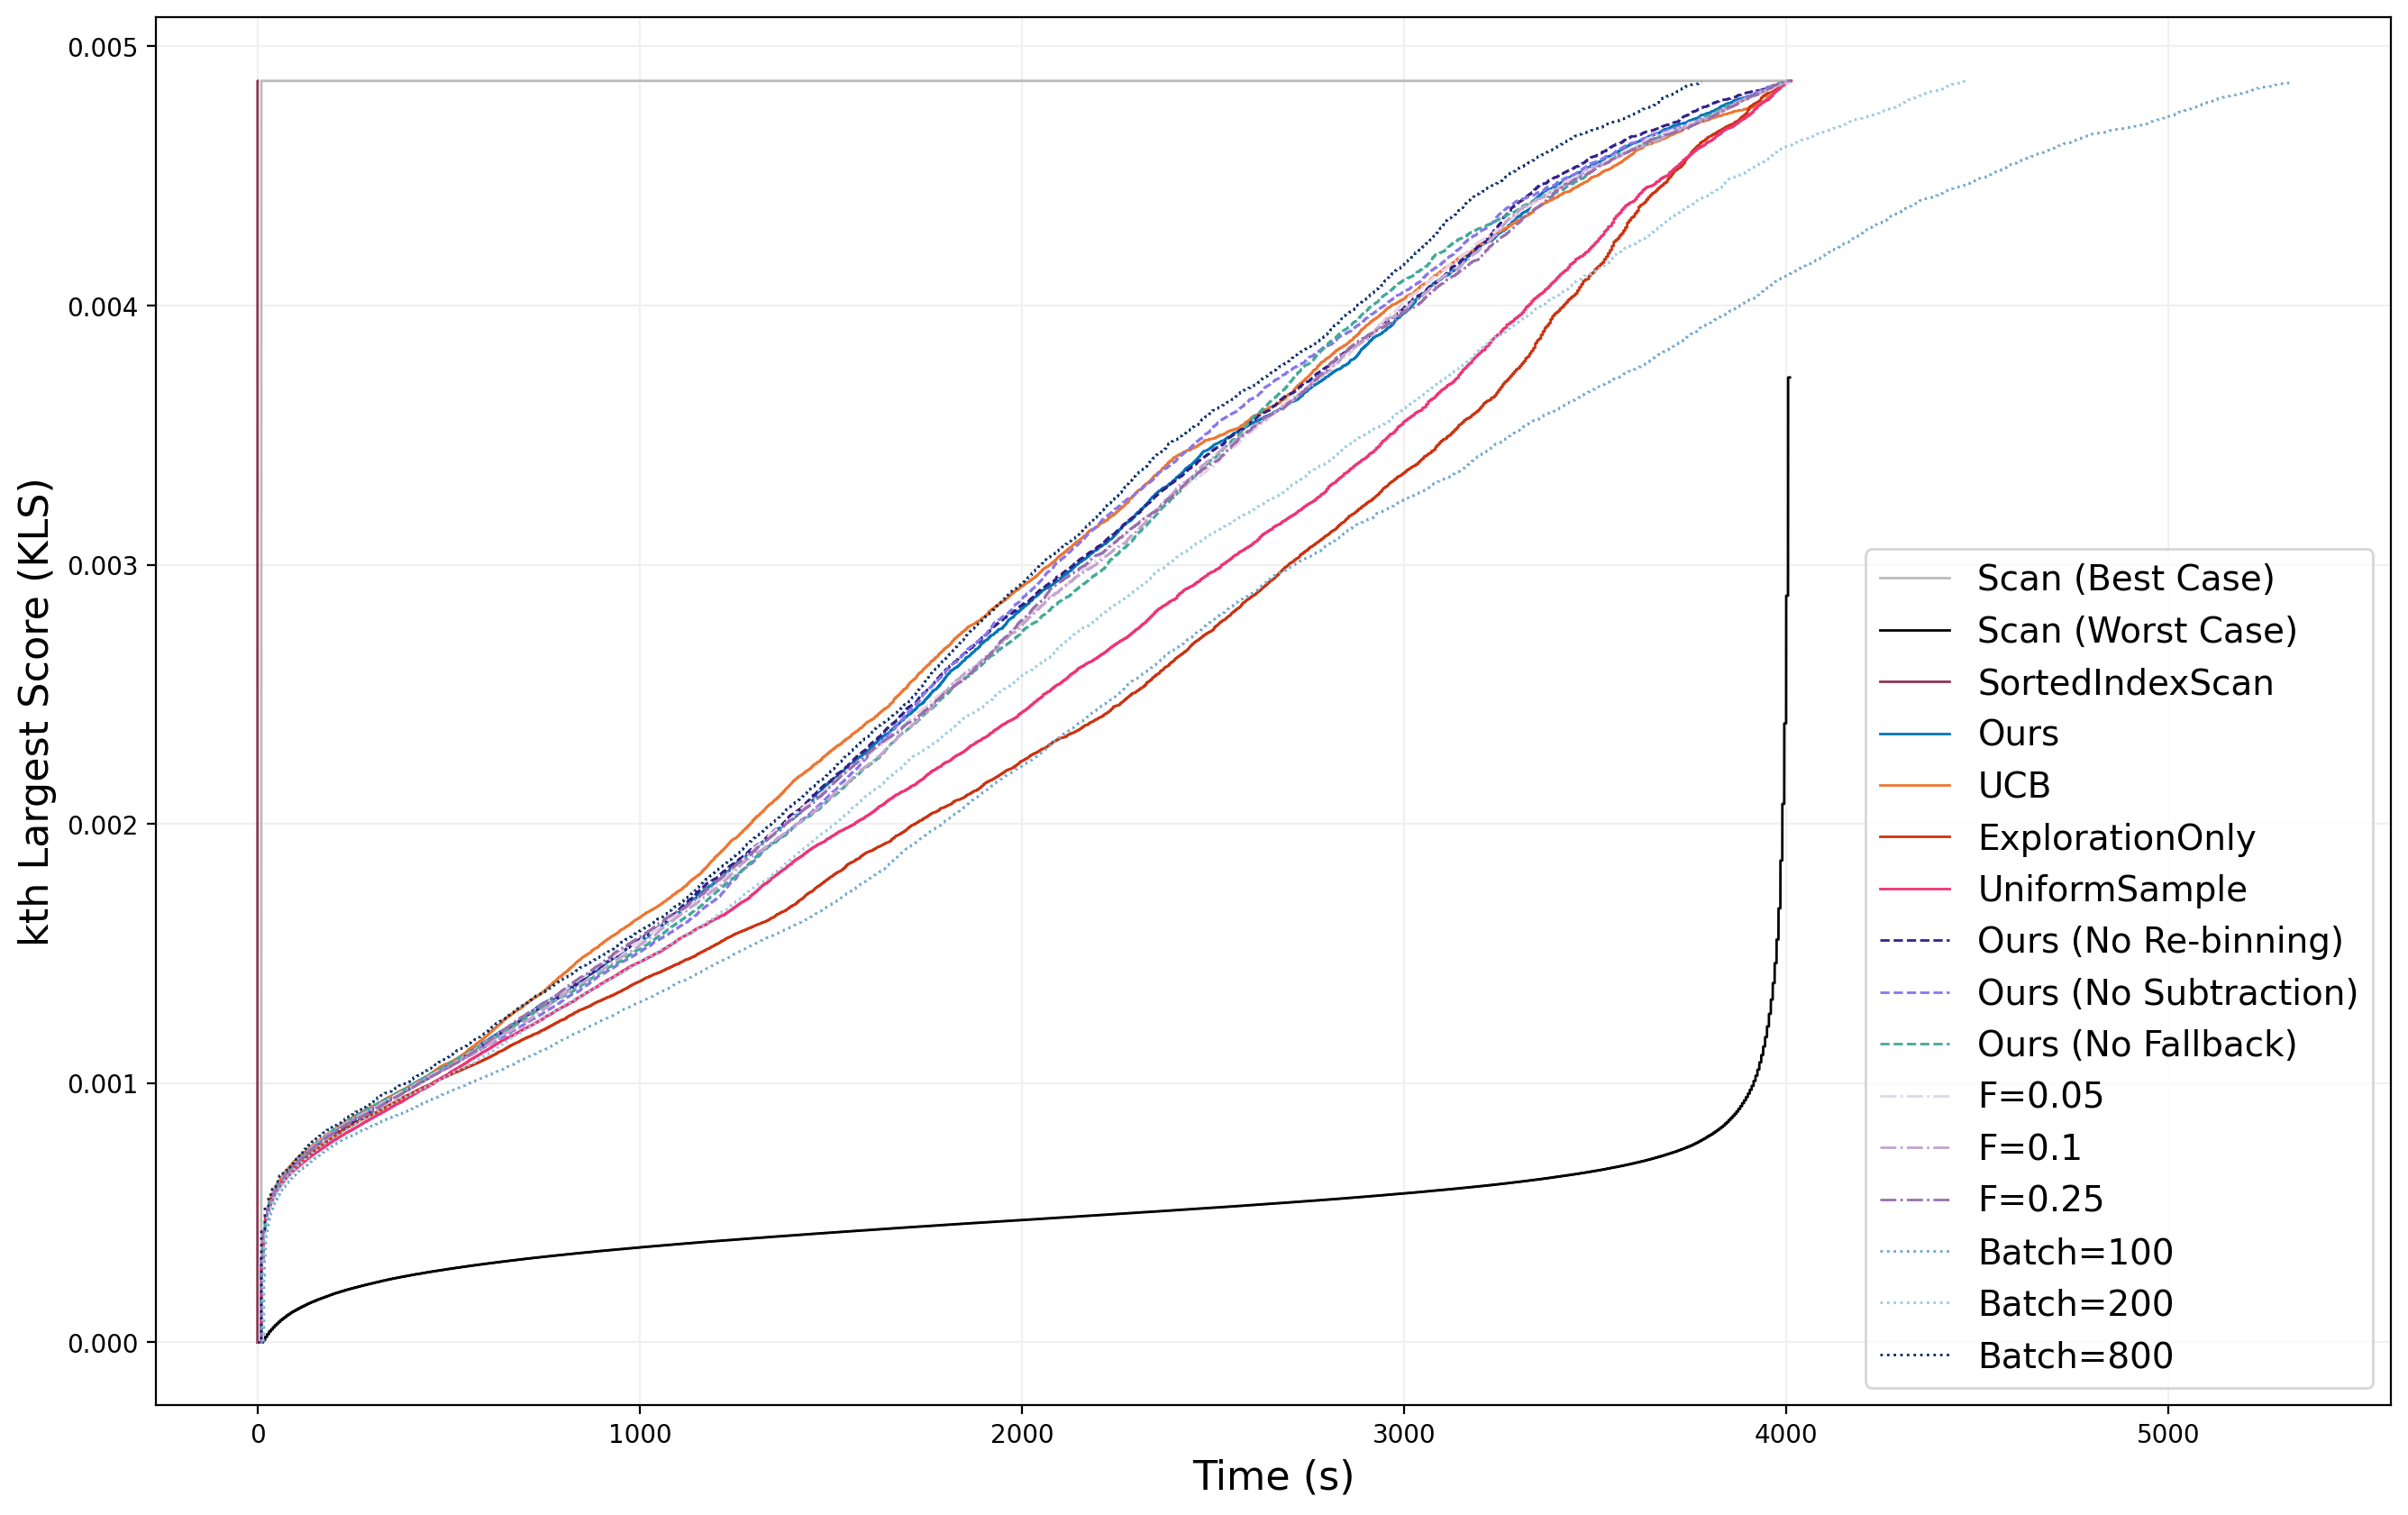

In [134]:
plot_metric_per_time_or_iter(statistics, 
                             order=None,
                             metric='KLS', 
                             x_axis='sec',
                             title=None, 
                             filename=None, 
                             ylabel="kth Largest Score (KLS)", 
                             xlabel=None,
                             xrange=None,
                             yrange=None,
                             linewidth=1.0)

### KLS vs Iteration

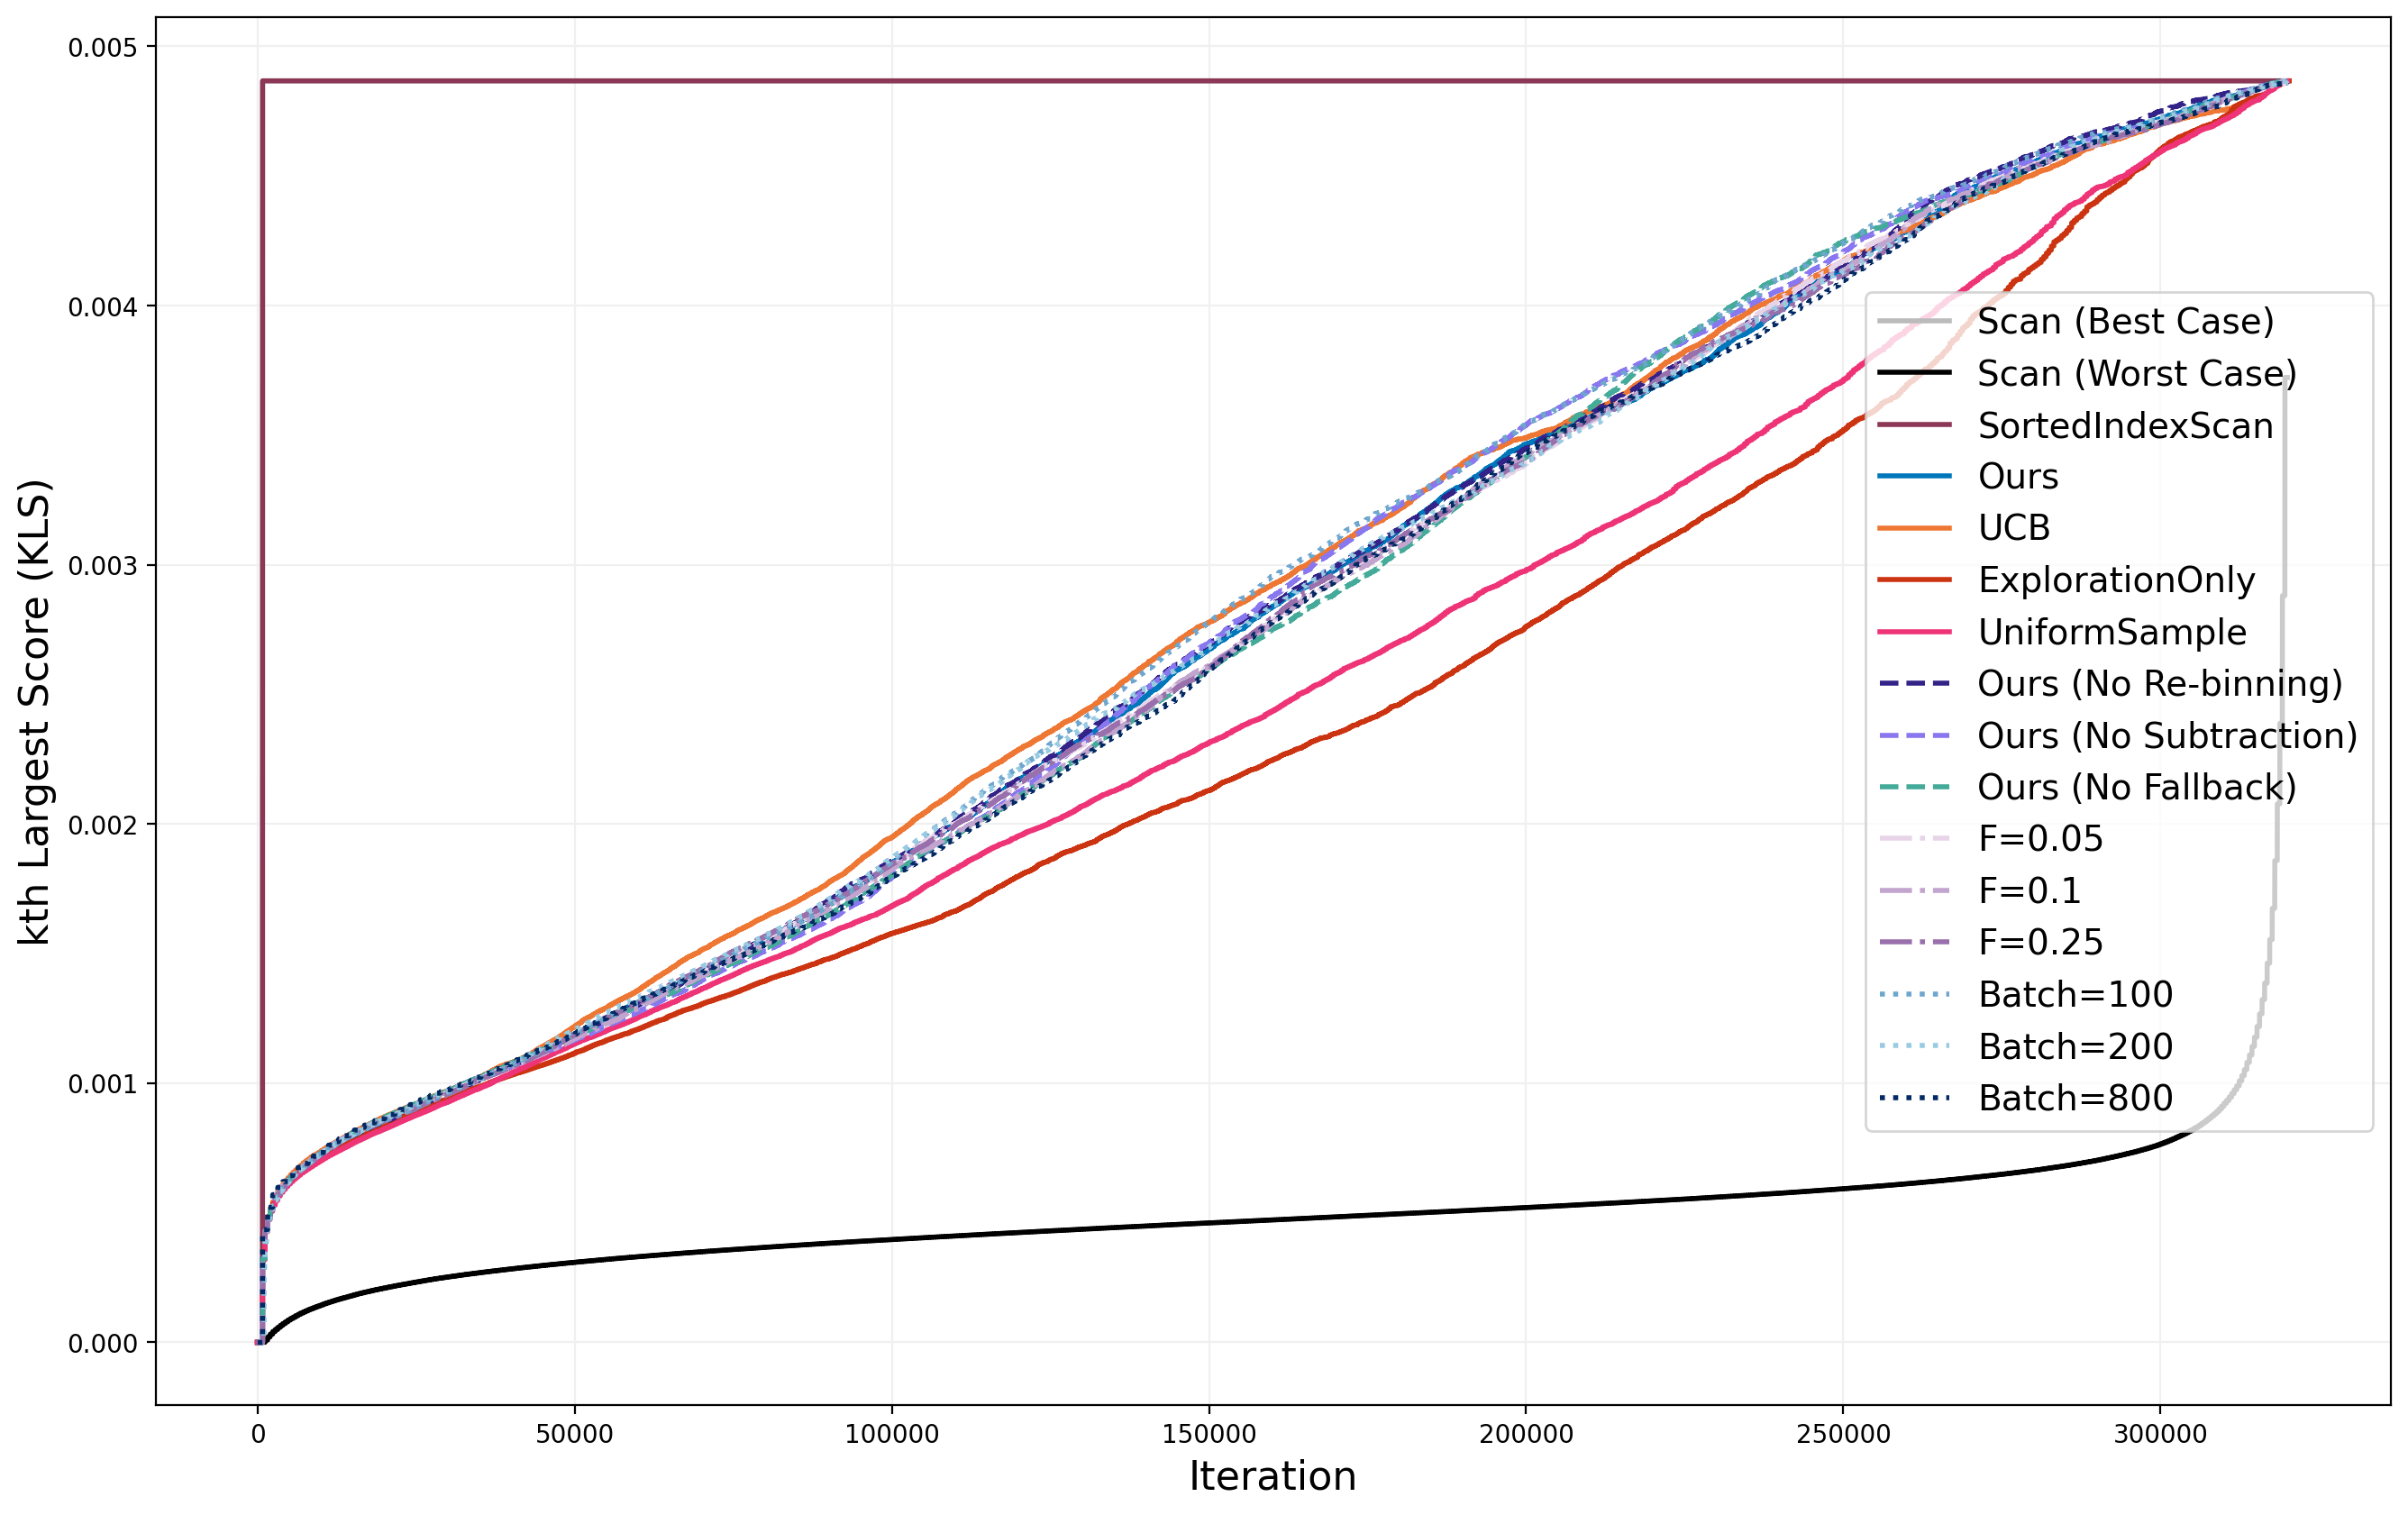

In [135]:
plot_metric_per_time_or_iter(statistics, 
                             order=None,
                             metric='KLS', 
                             x_axis='iteration',
                             title=None, 
                             filename=None, 
                             ylabel="kth Largest Score (KLS)", 
                             xlabel=None,
                             xrange=None,
                             yrange=None,
                             linewidth=2.0)

### Precision vs Time

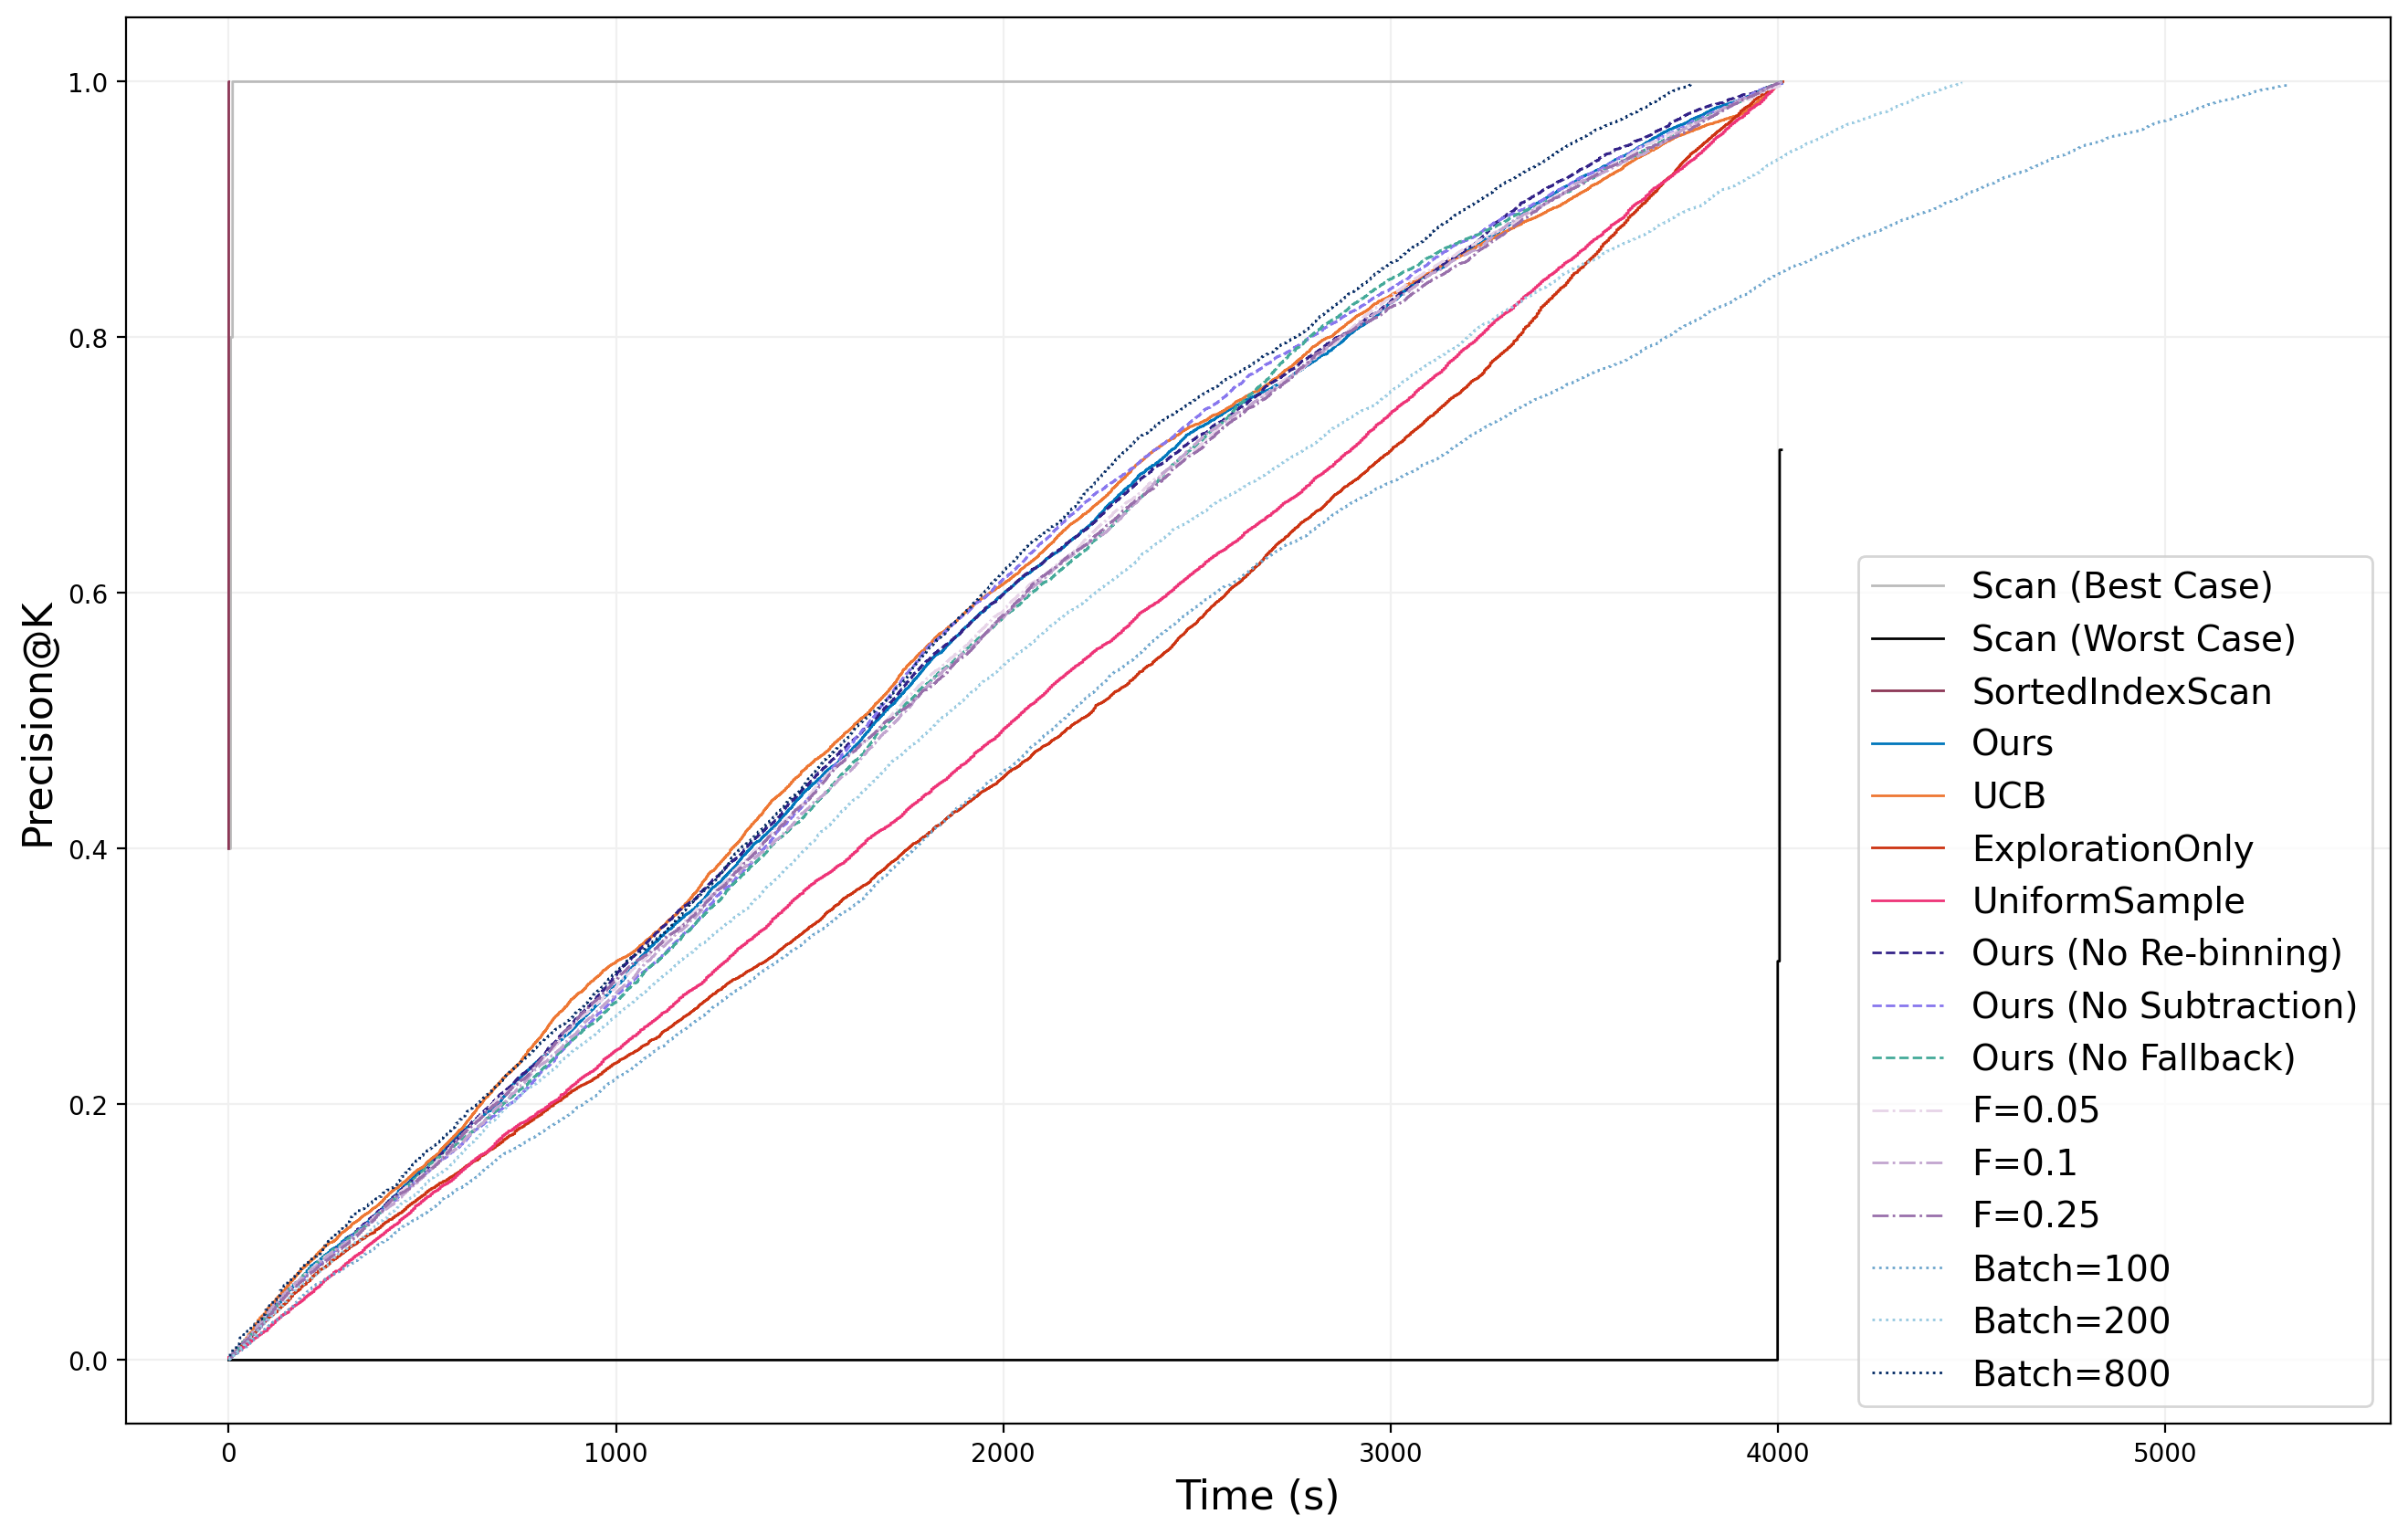

In [136]:
plot_metric_per_time_or_iter(statistics, 
                             order=None,
                             metric='Precision@K',
                             x_axis='sec', 
                             title=None,
                             filename=None,
                             ylabel="Precision@K",
                             yrange=None,
                             linewidth=1.0,
                             y_log=False,
                             legend_loc="lower right")

### Precision vs Iteration

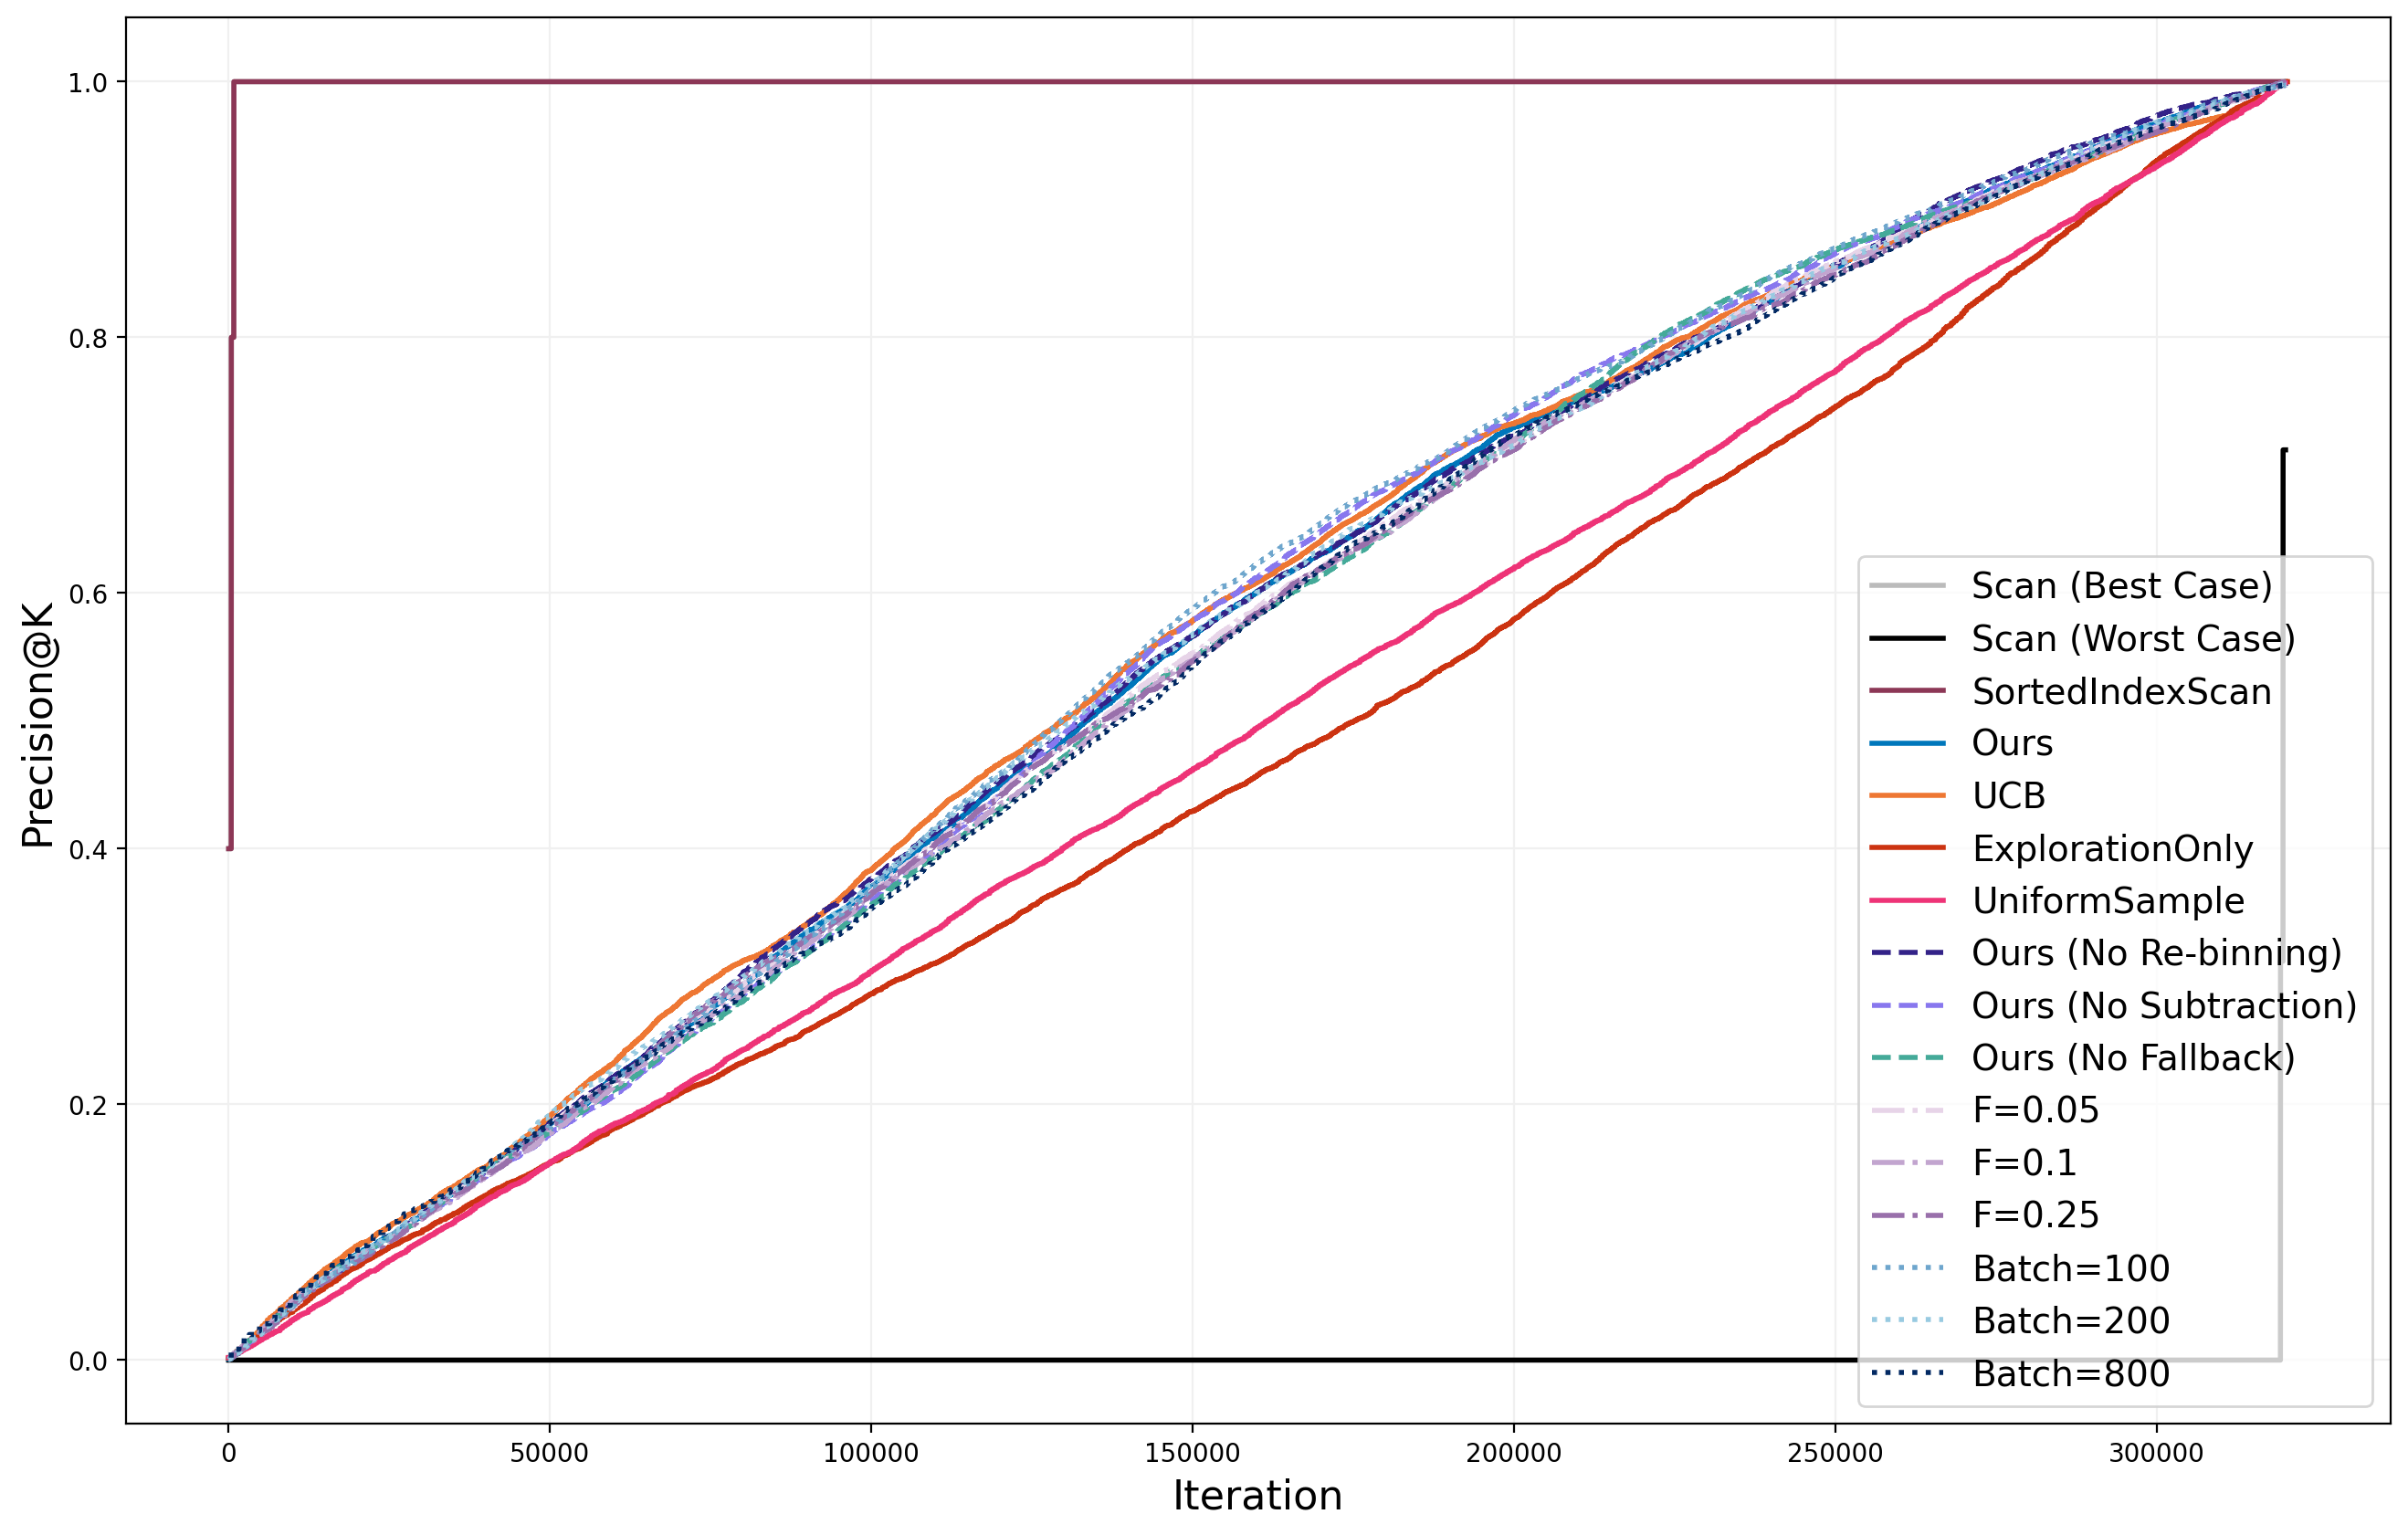

In [137]:
plot_metric_per_time_or_iter(statistics, 
                             order=None,
                             metric='Precision@K',
                             x_axis='iteration', 
                             title=None,
                             filename=None,
                             ylabel="Precision@K",
                             yrange=None,
                             linewidth=2.0,
                             legend_loc='lower right')

### Recall vs time

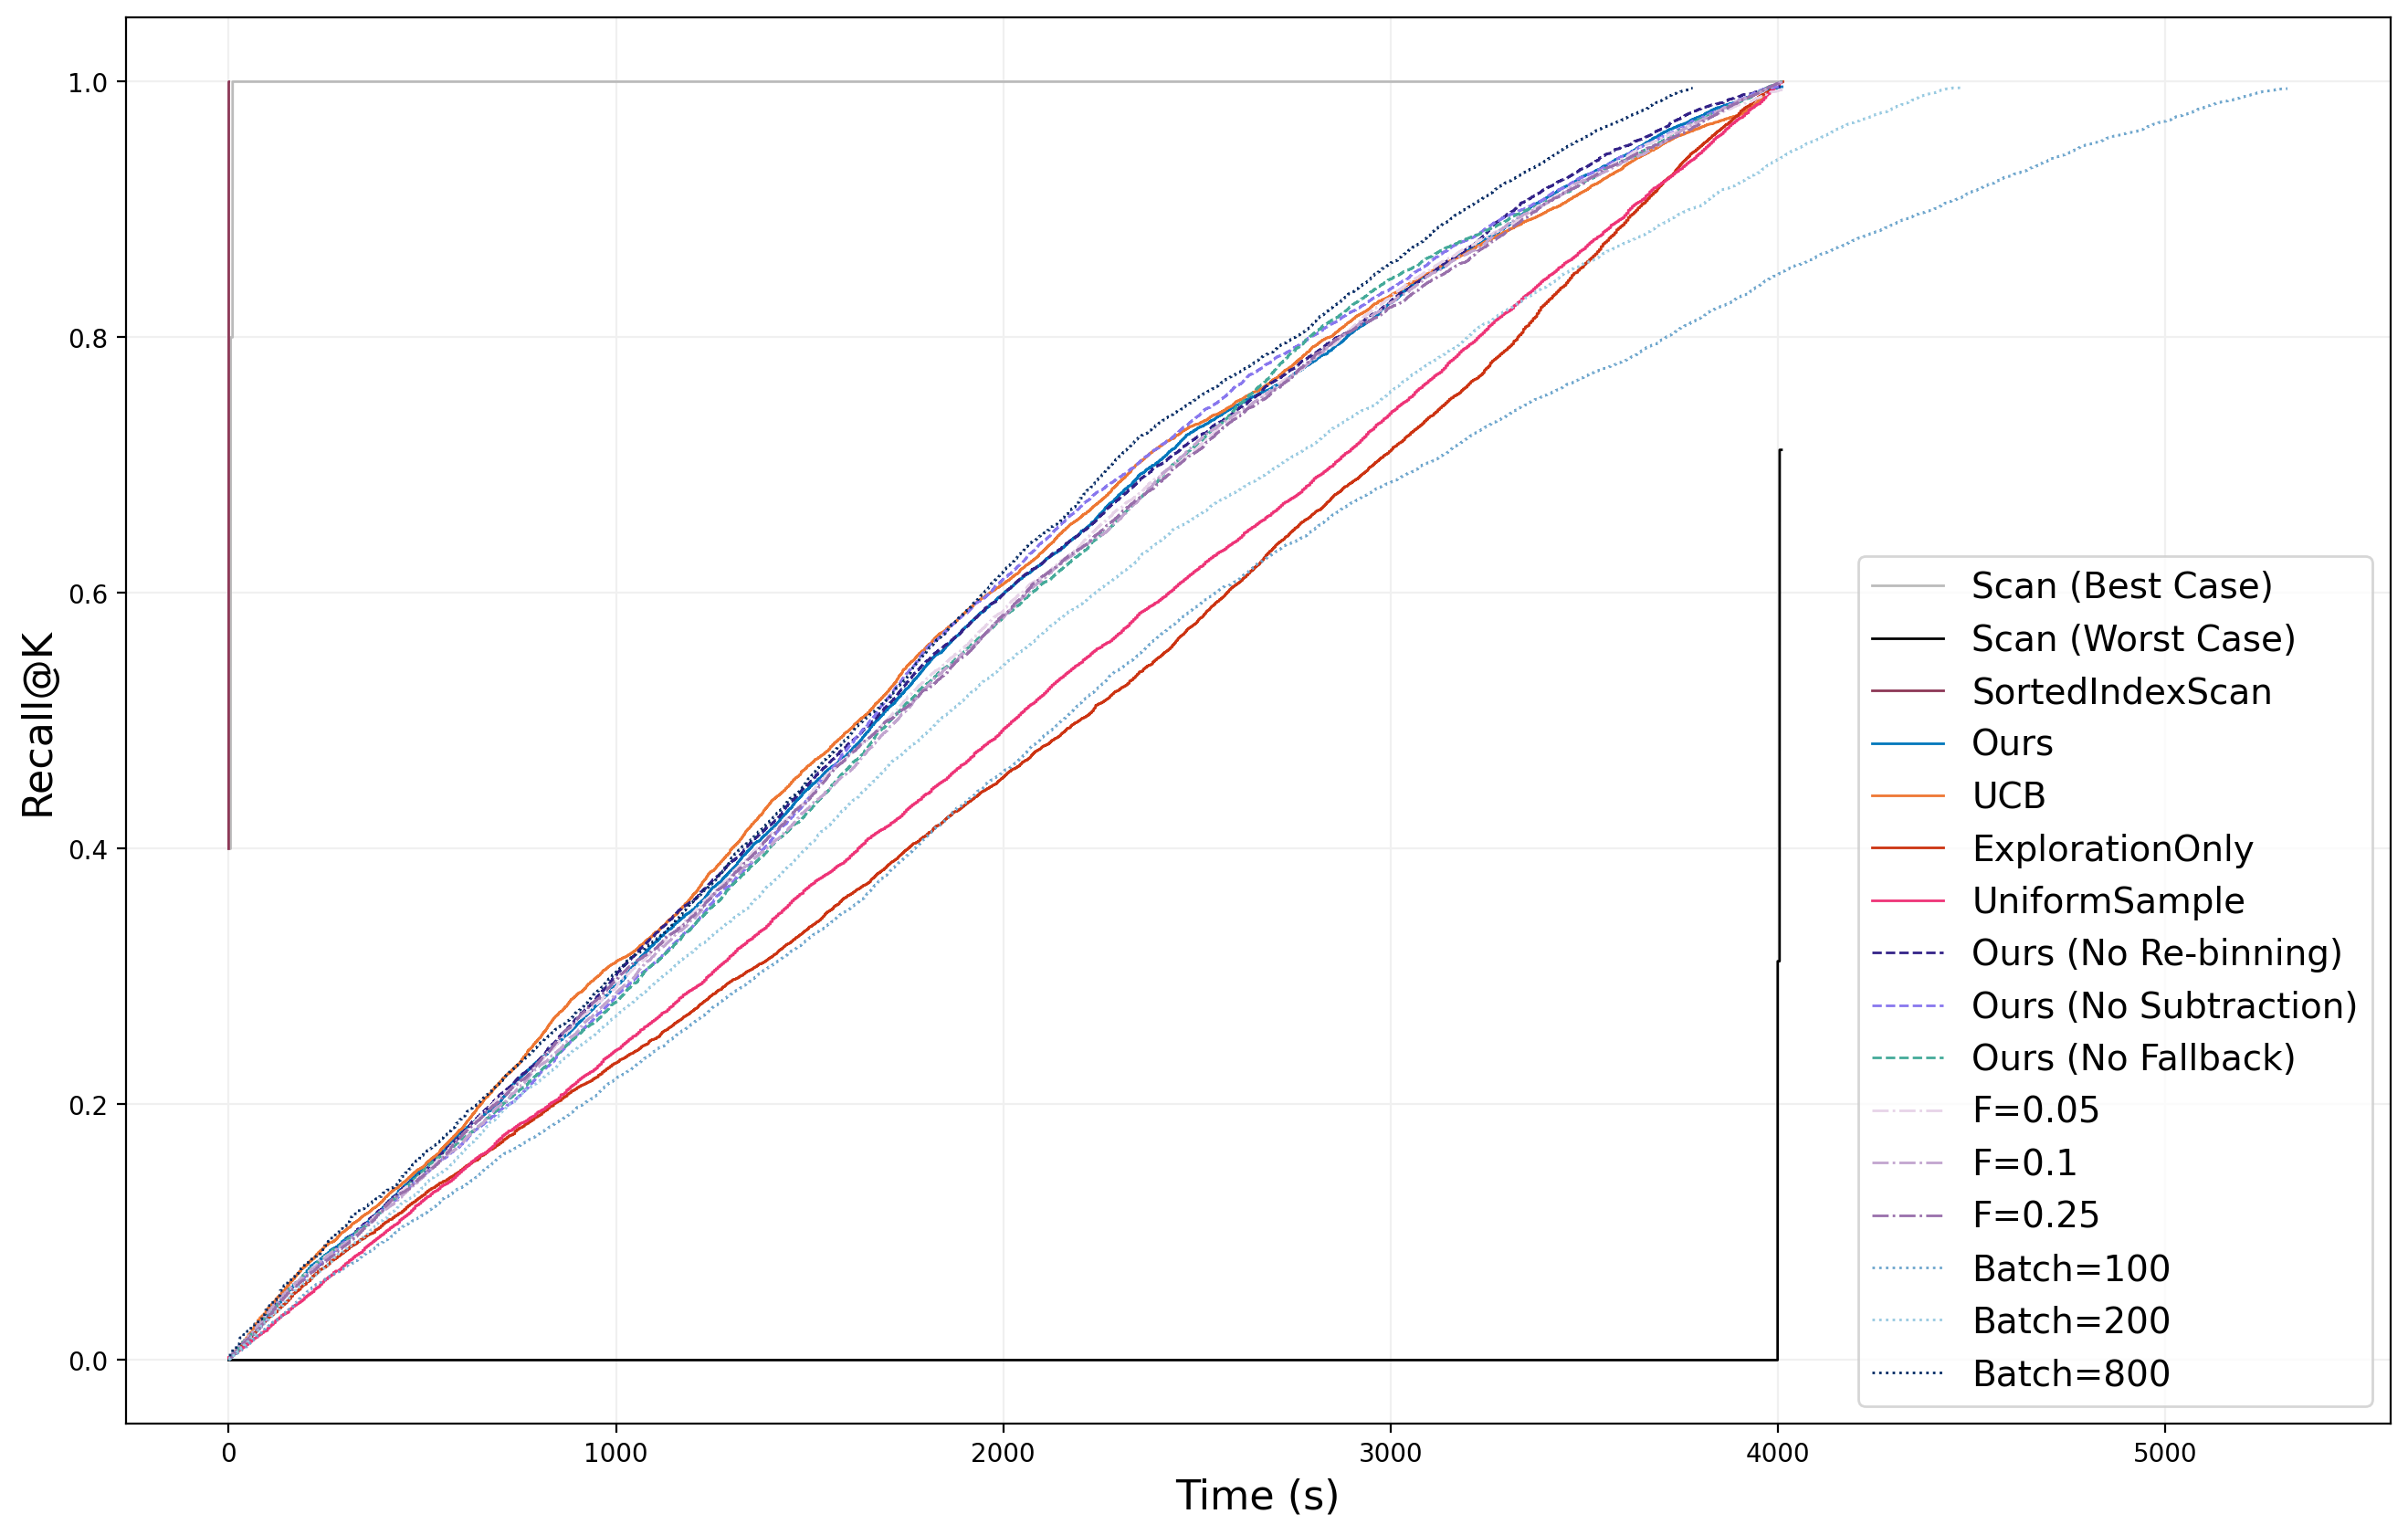

In [138]:
plot_metric_per_time_or_iter(statistics,
                             order=None,
                             metric='Recall@K',
                             x_axis='sec', 
                             title=None, 
                             filename=None, 
                             ylabel="Recall@K",
                             linewidth=1.0,
                             yrange=None)

### Recall vs iteration

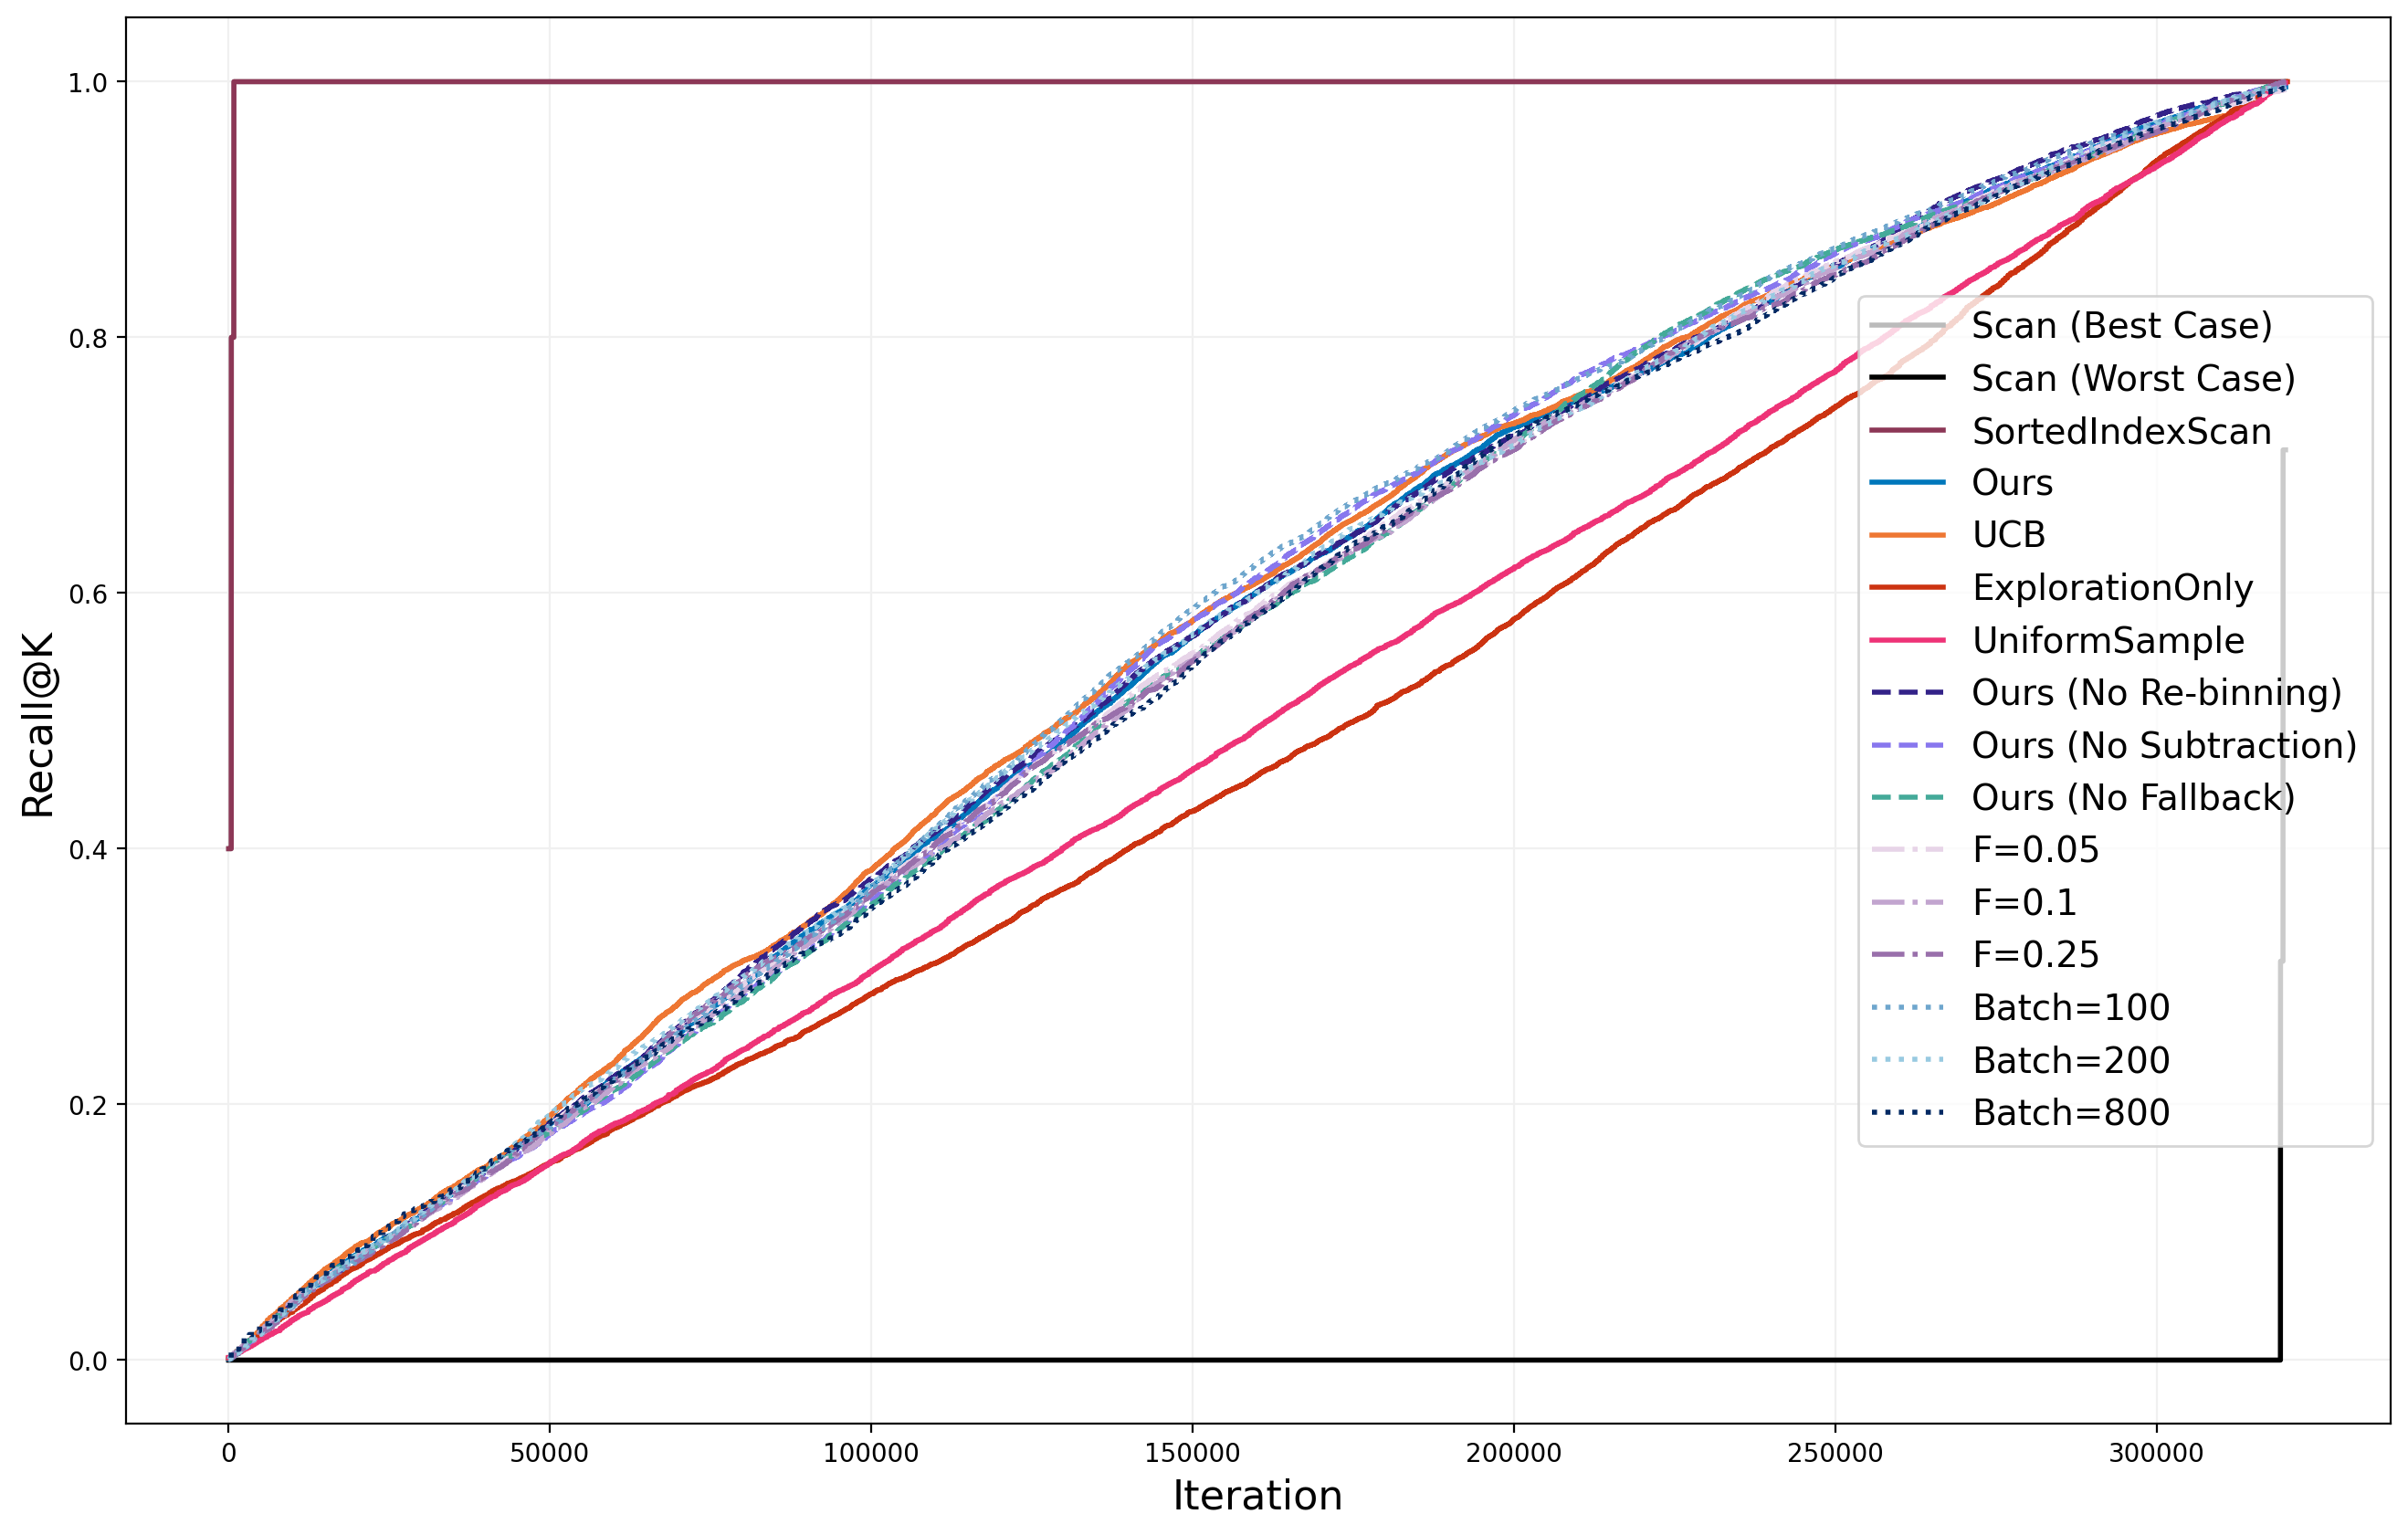

In [139]:
plot_metric_per_time_or_iter(statistics,
                             order=None,
                             metric='Recall@K',
                             x_axis='iteration', 
                             title=None, 
                             filename=None, 
                             ylabel="Recall@K",
                             linewidth=2.0,
                             yrange=None)

### Average Rank vs time

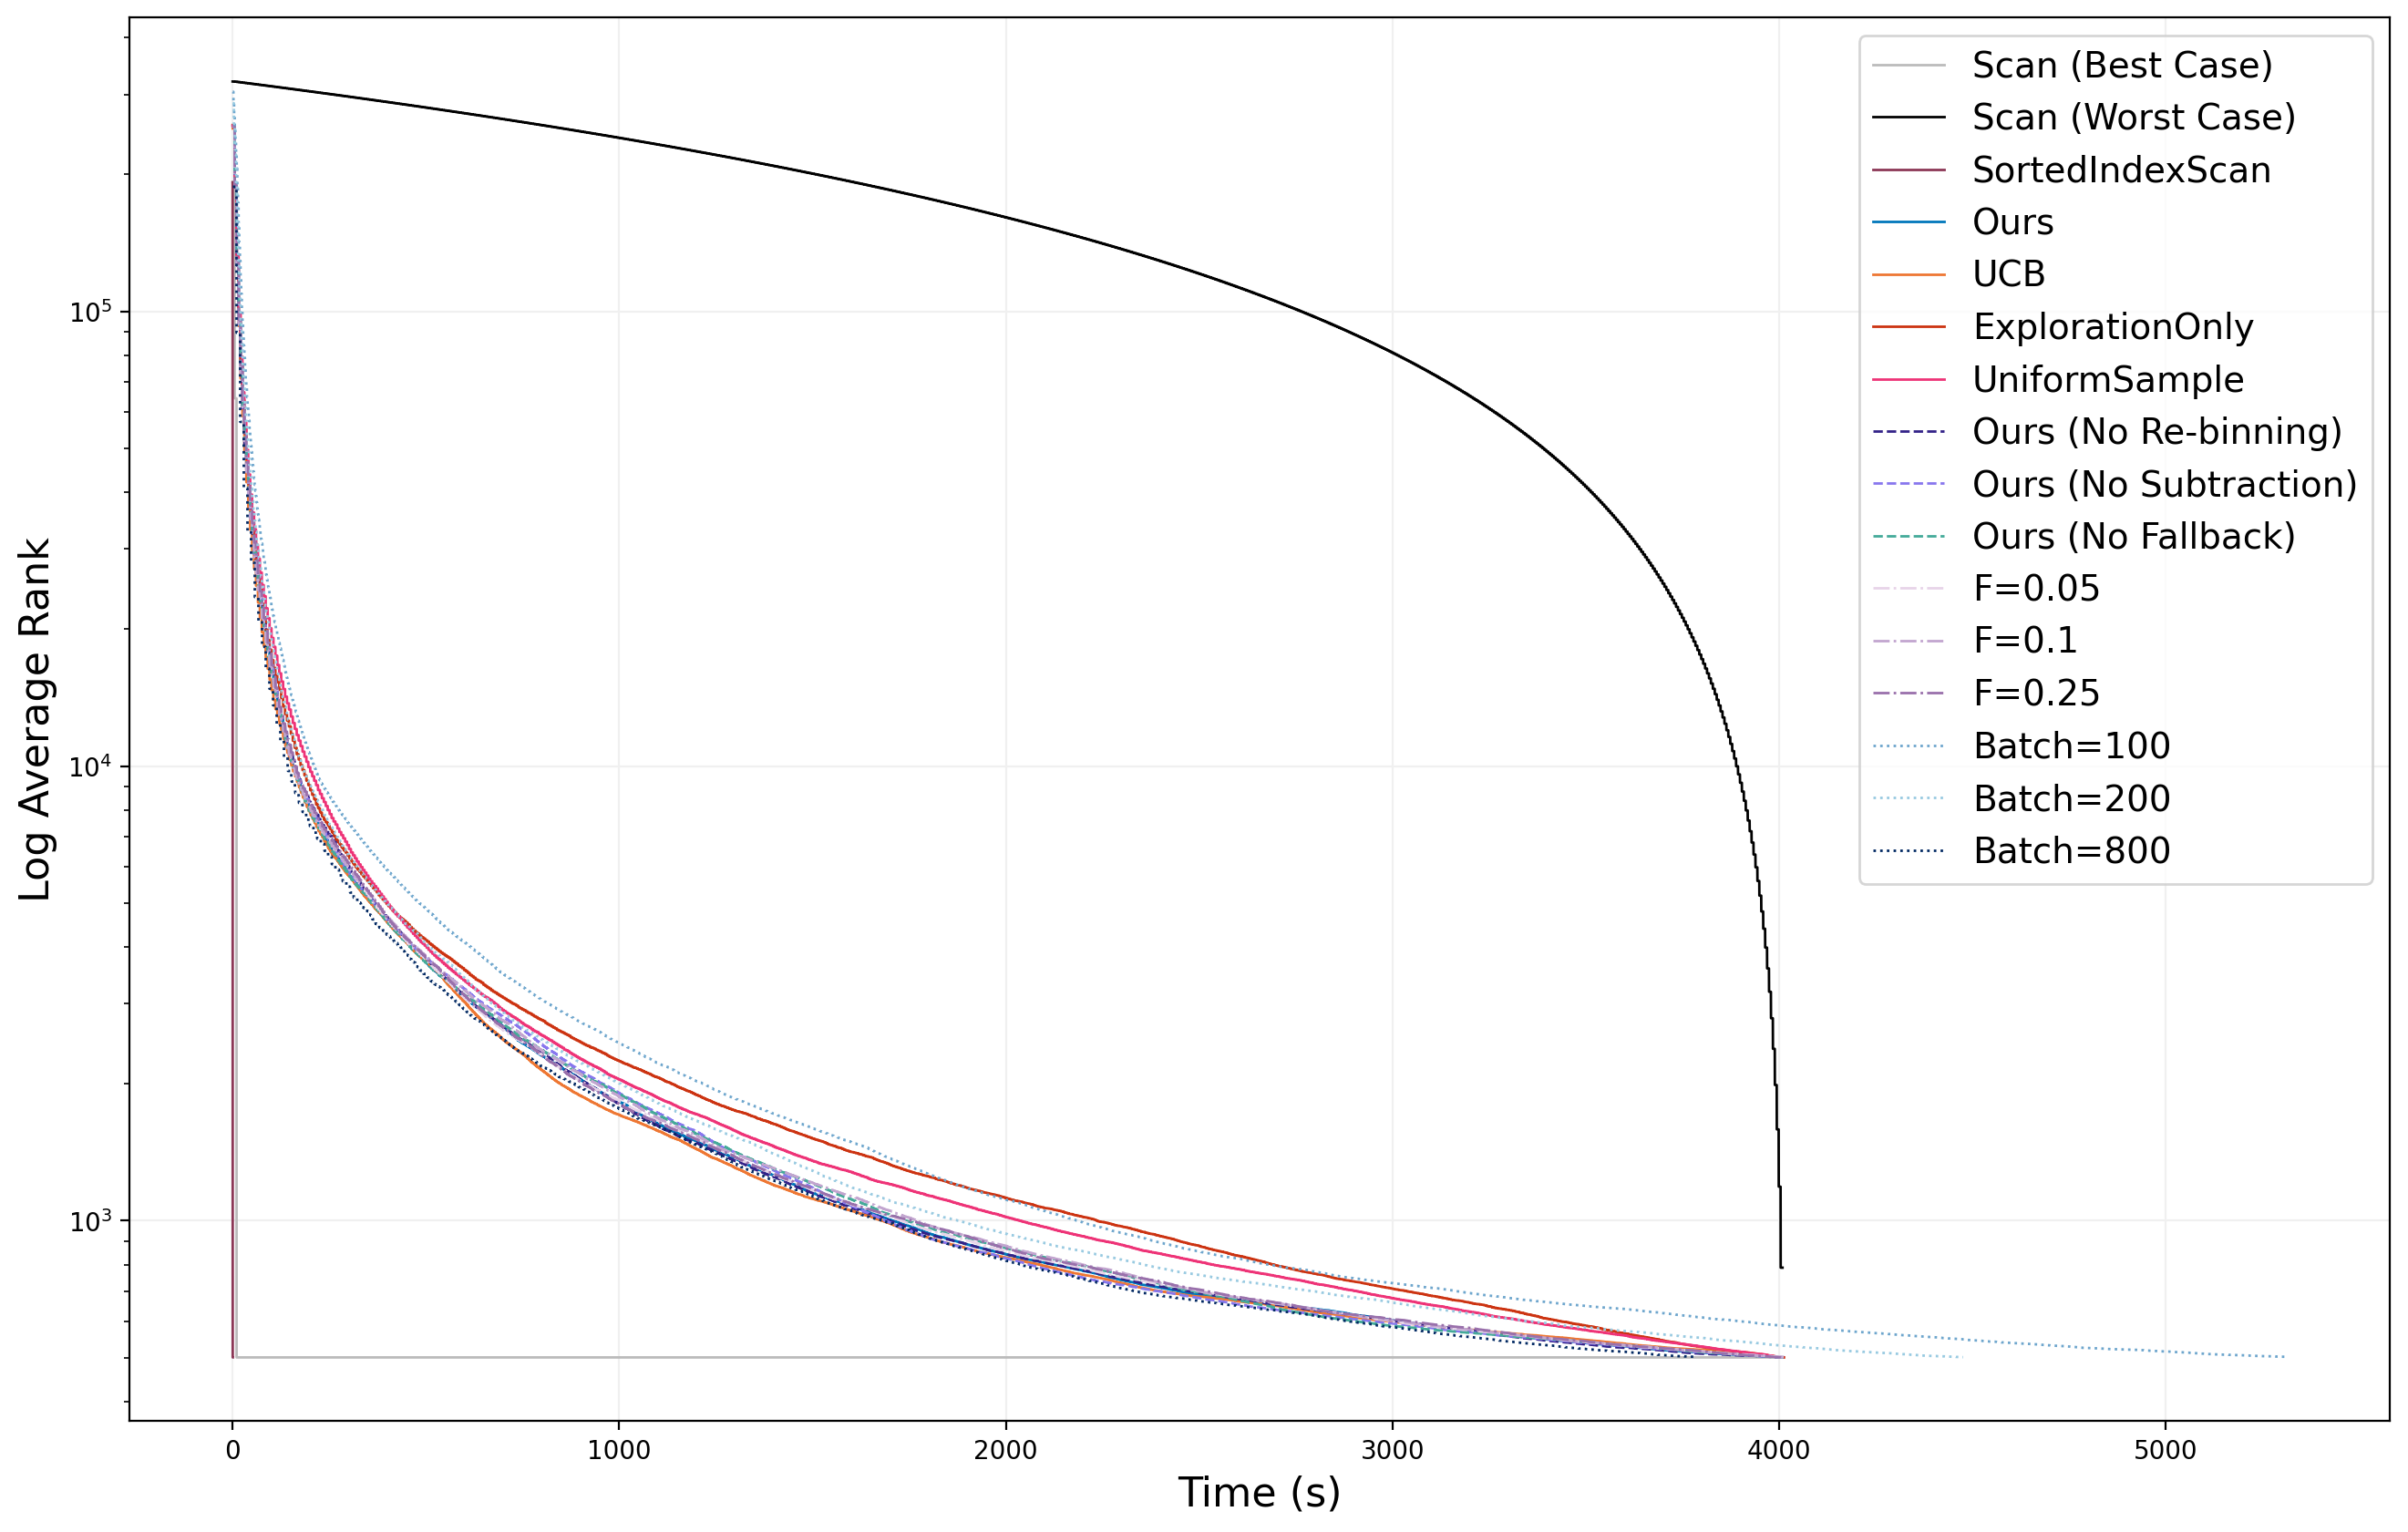

In [140]:
plot_metric_per_time_or_iter(statistics, 
                             order=None,
                             metric='AvgRank', 
                             x_axis='sec', 
                             y_log=True, 
                             ylabel='Log Average Rank',
                             title=None,
                             filename=None,
                             linewidth=1.0)

### Average Rank vs Iteration

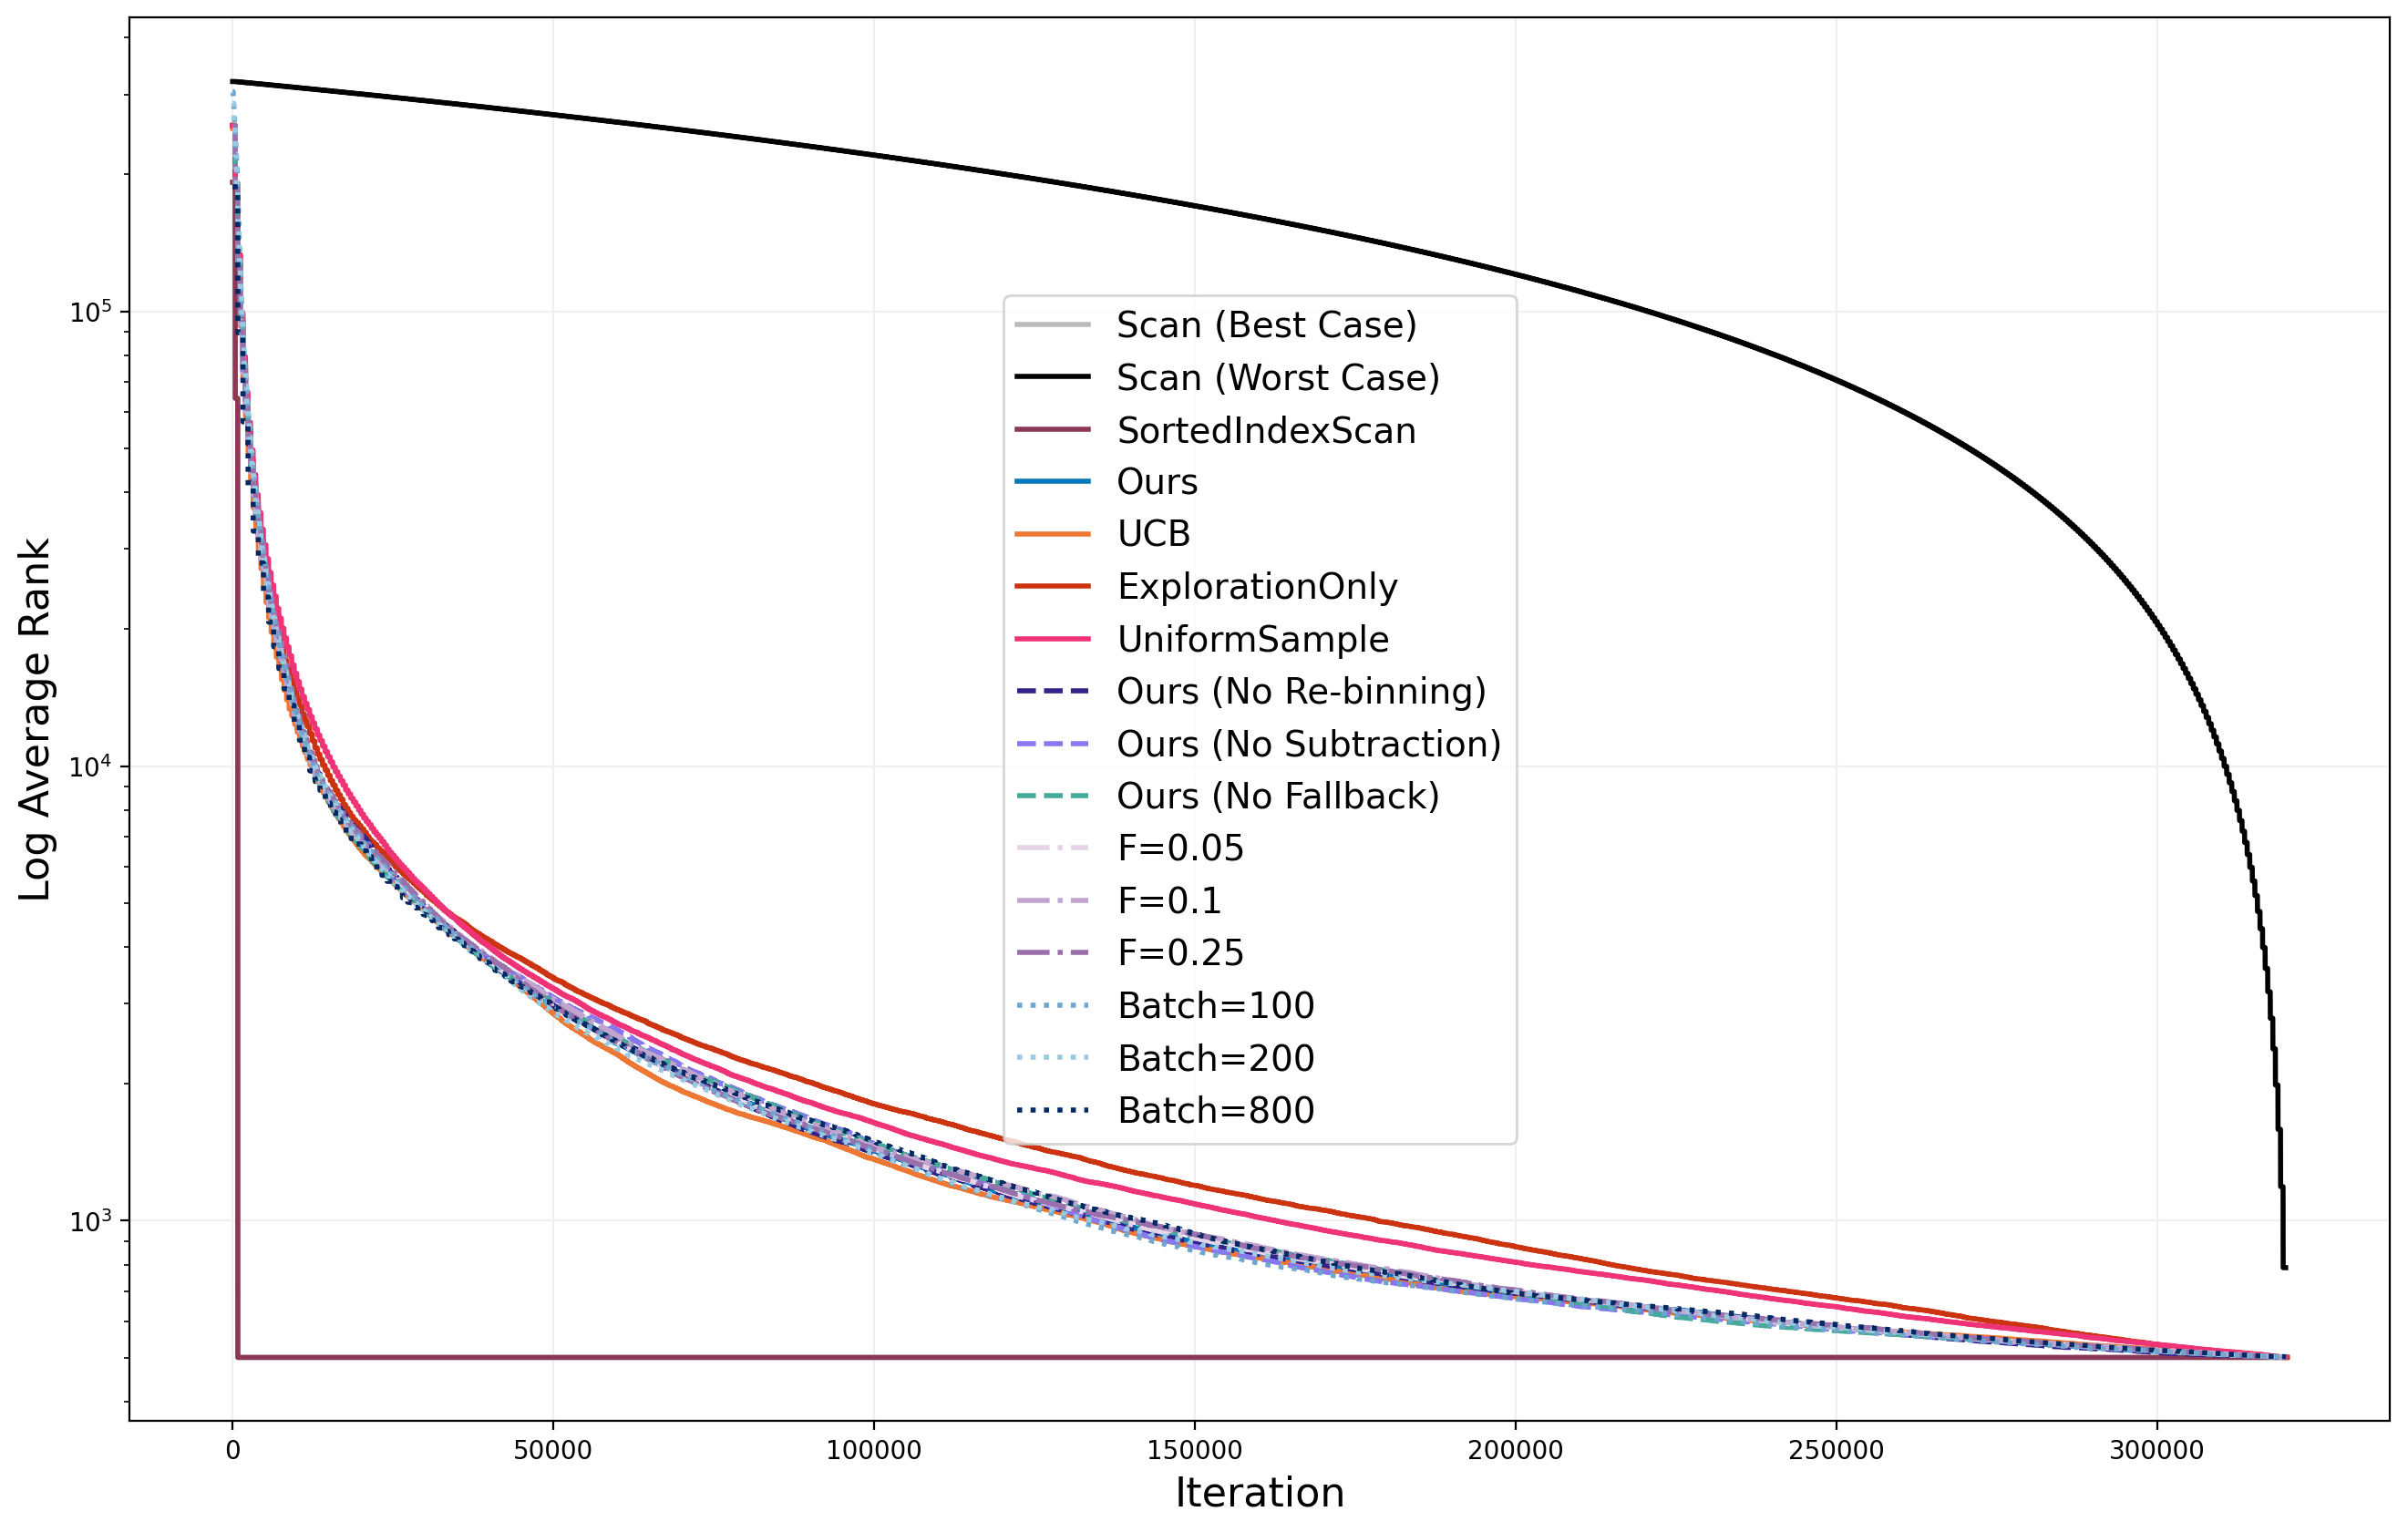

In [141]:
plot_metric_per_time_or_iter(statistics, 
                             order=None,
                             metric='AvgRank', 
                             x_axis='iteration', 
                             y_log=True, 
                             ylabel='Log Average Rank',
                             title=None,
                             filename=None,
                             linewidth=2.0)

### WorstRank vs Time

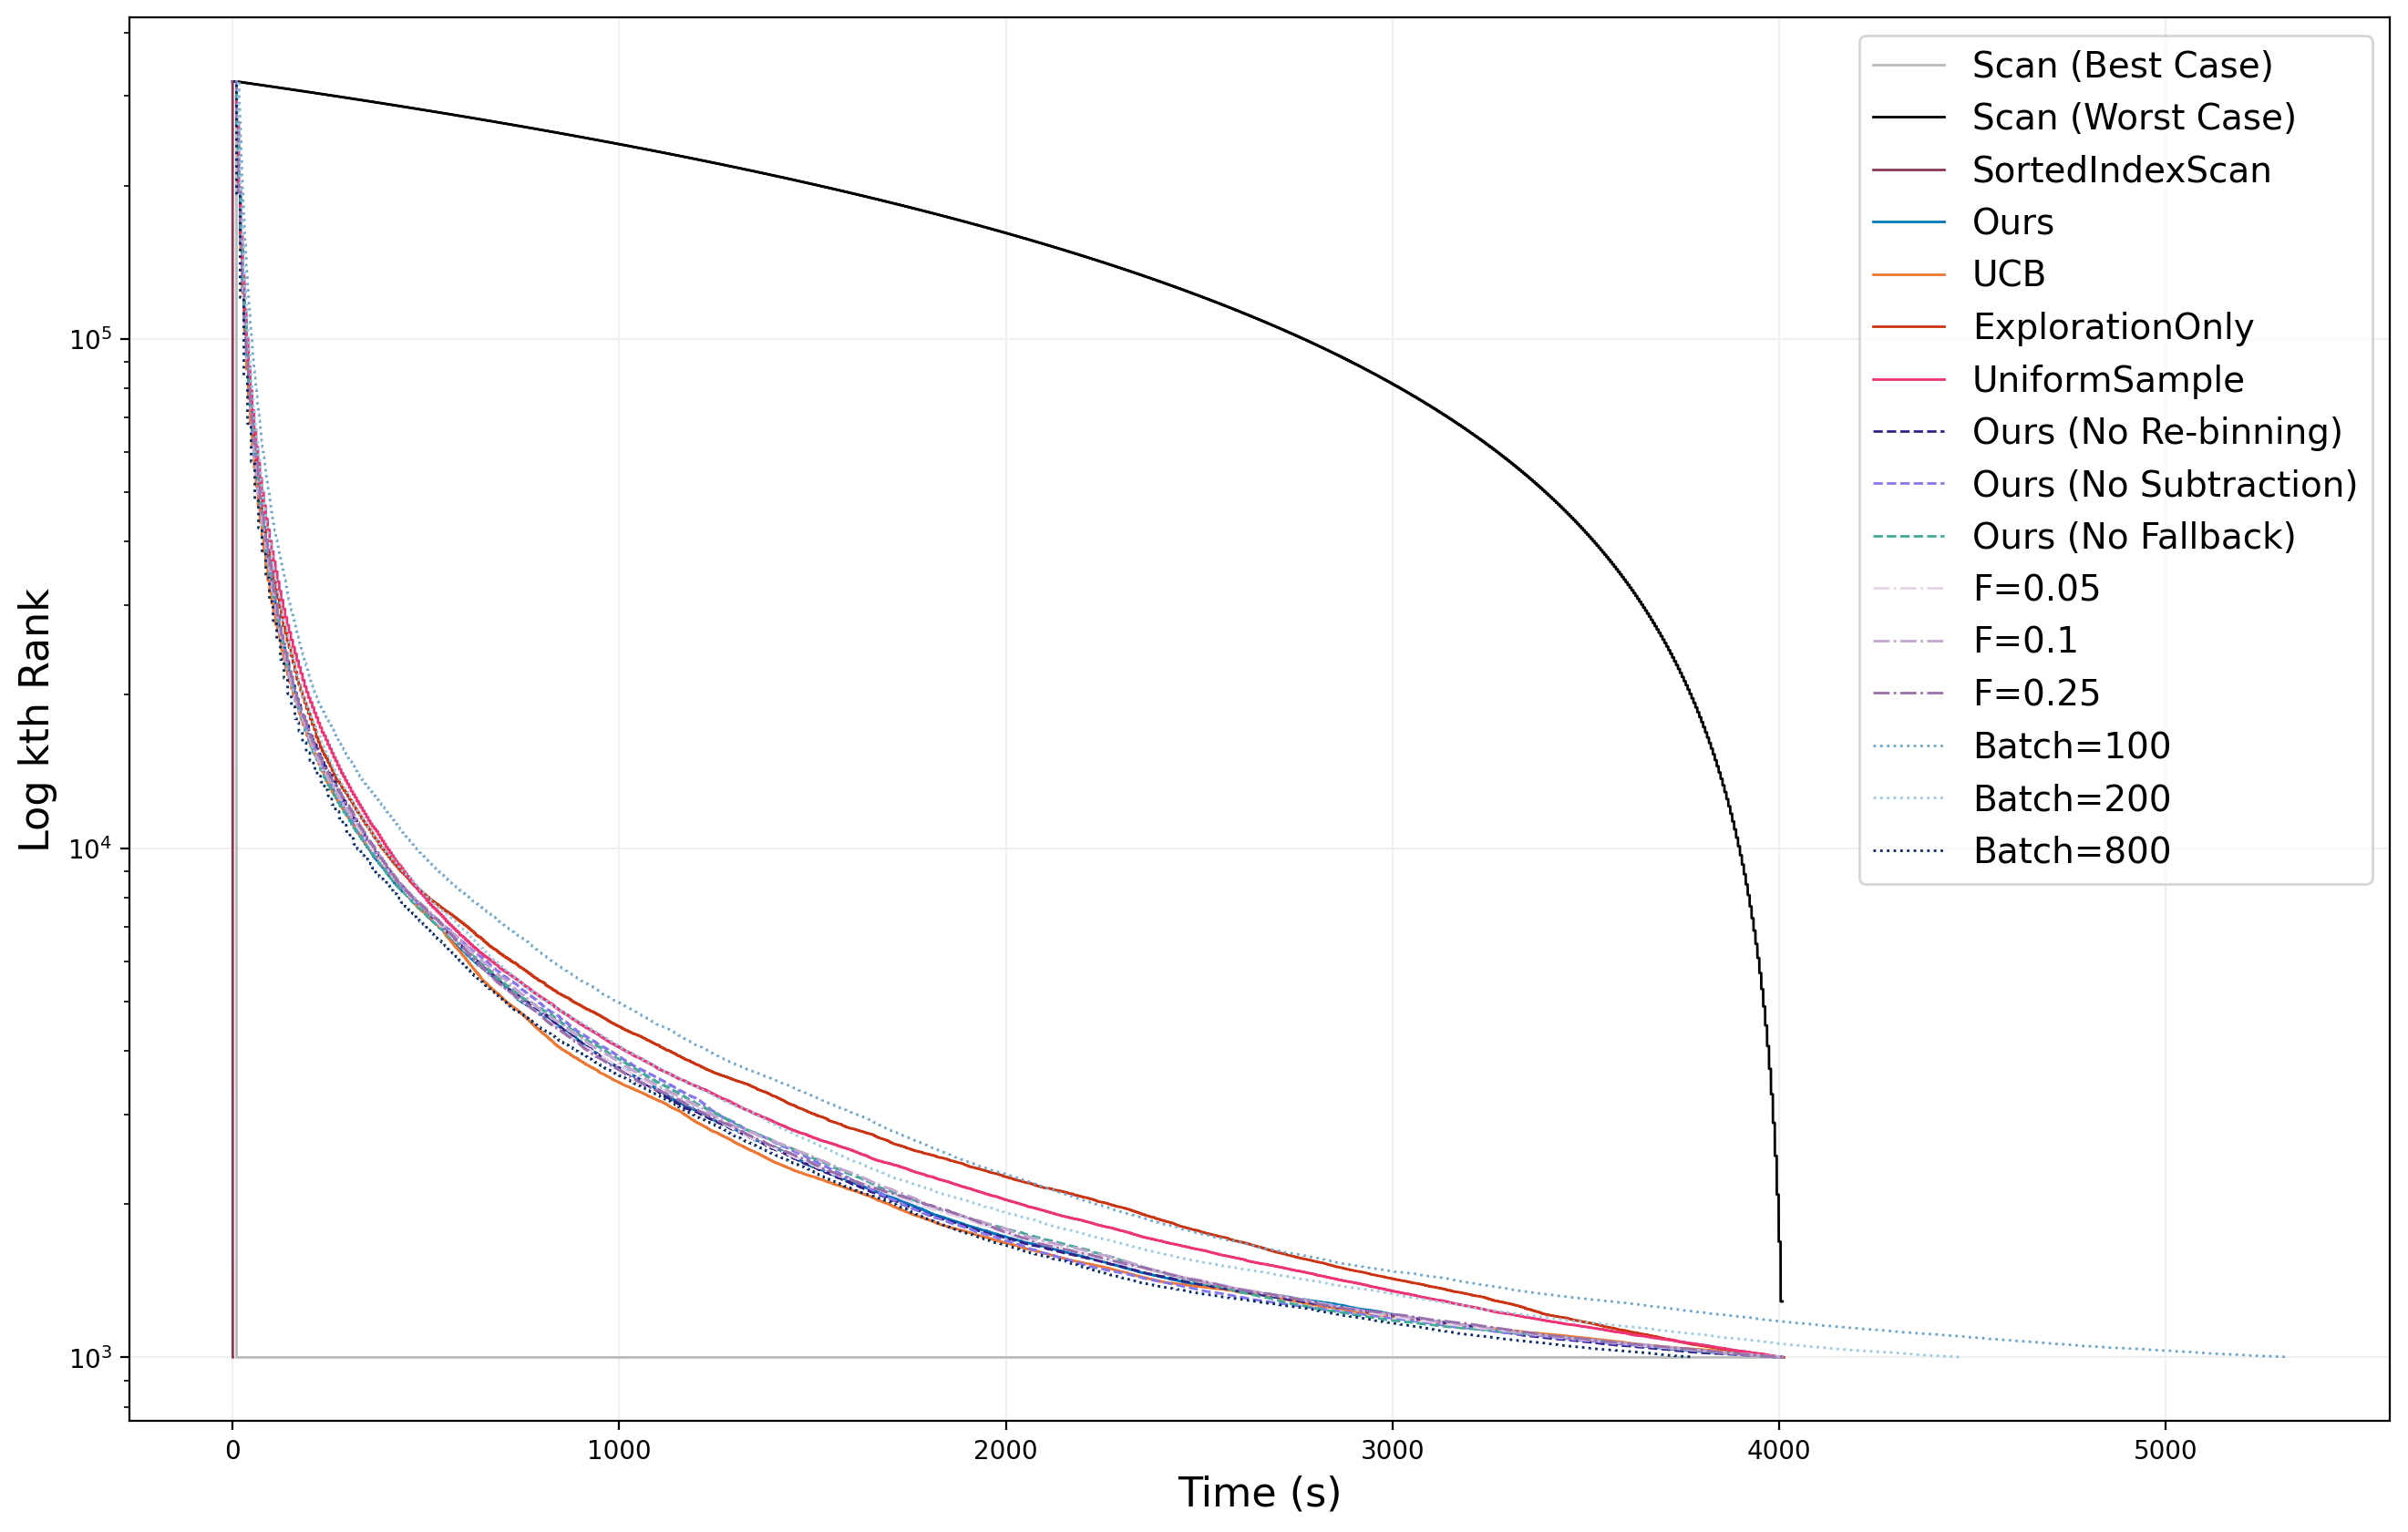

In [142]:
plot_metric_per_time_or_iter(statistics,
                             order=None,
                             metric='WorstRank',
                             x_axis='sec',
                             y_log=True, 
                             ylabel='Log kth Rank', 
                             title=None, 
                             filename=None,
                             linewidth=1.0)

### WorstRank vs Iteration

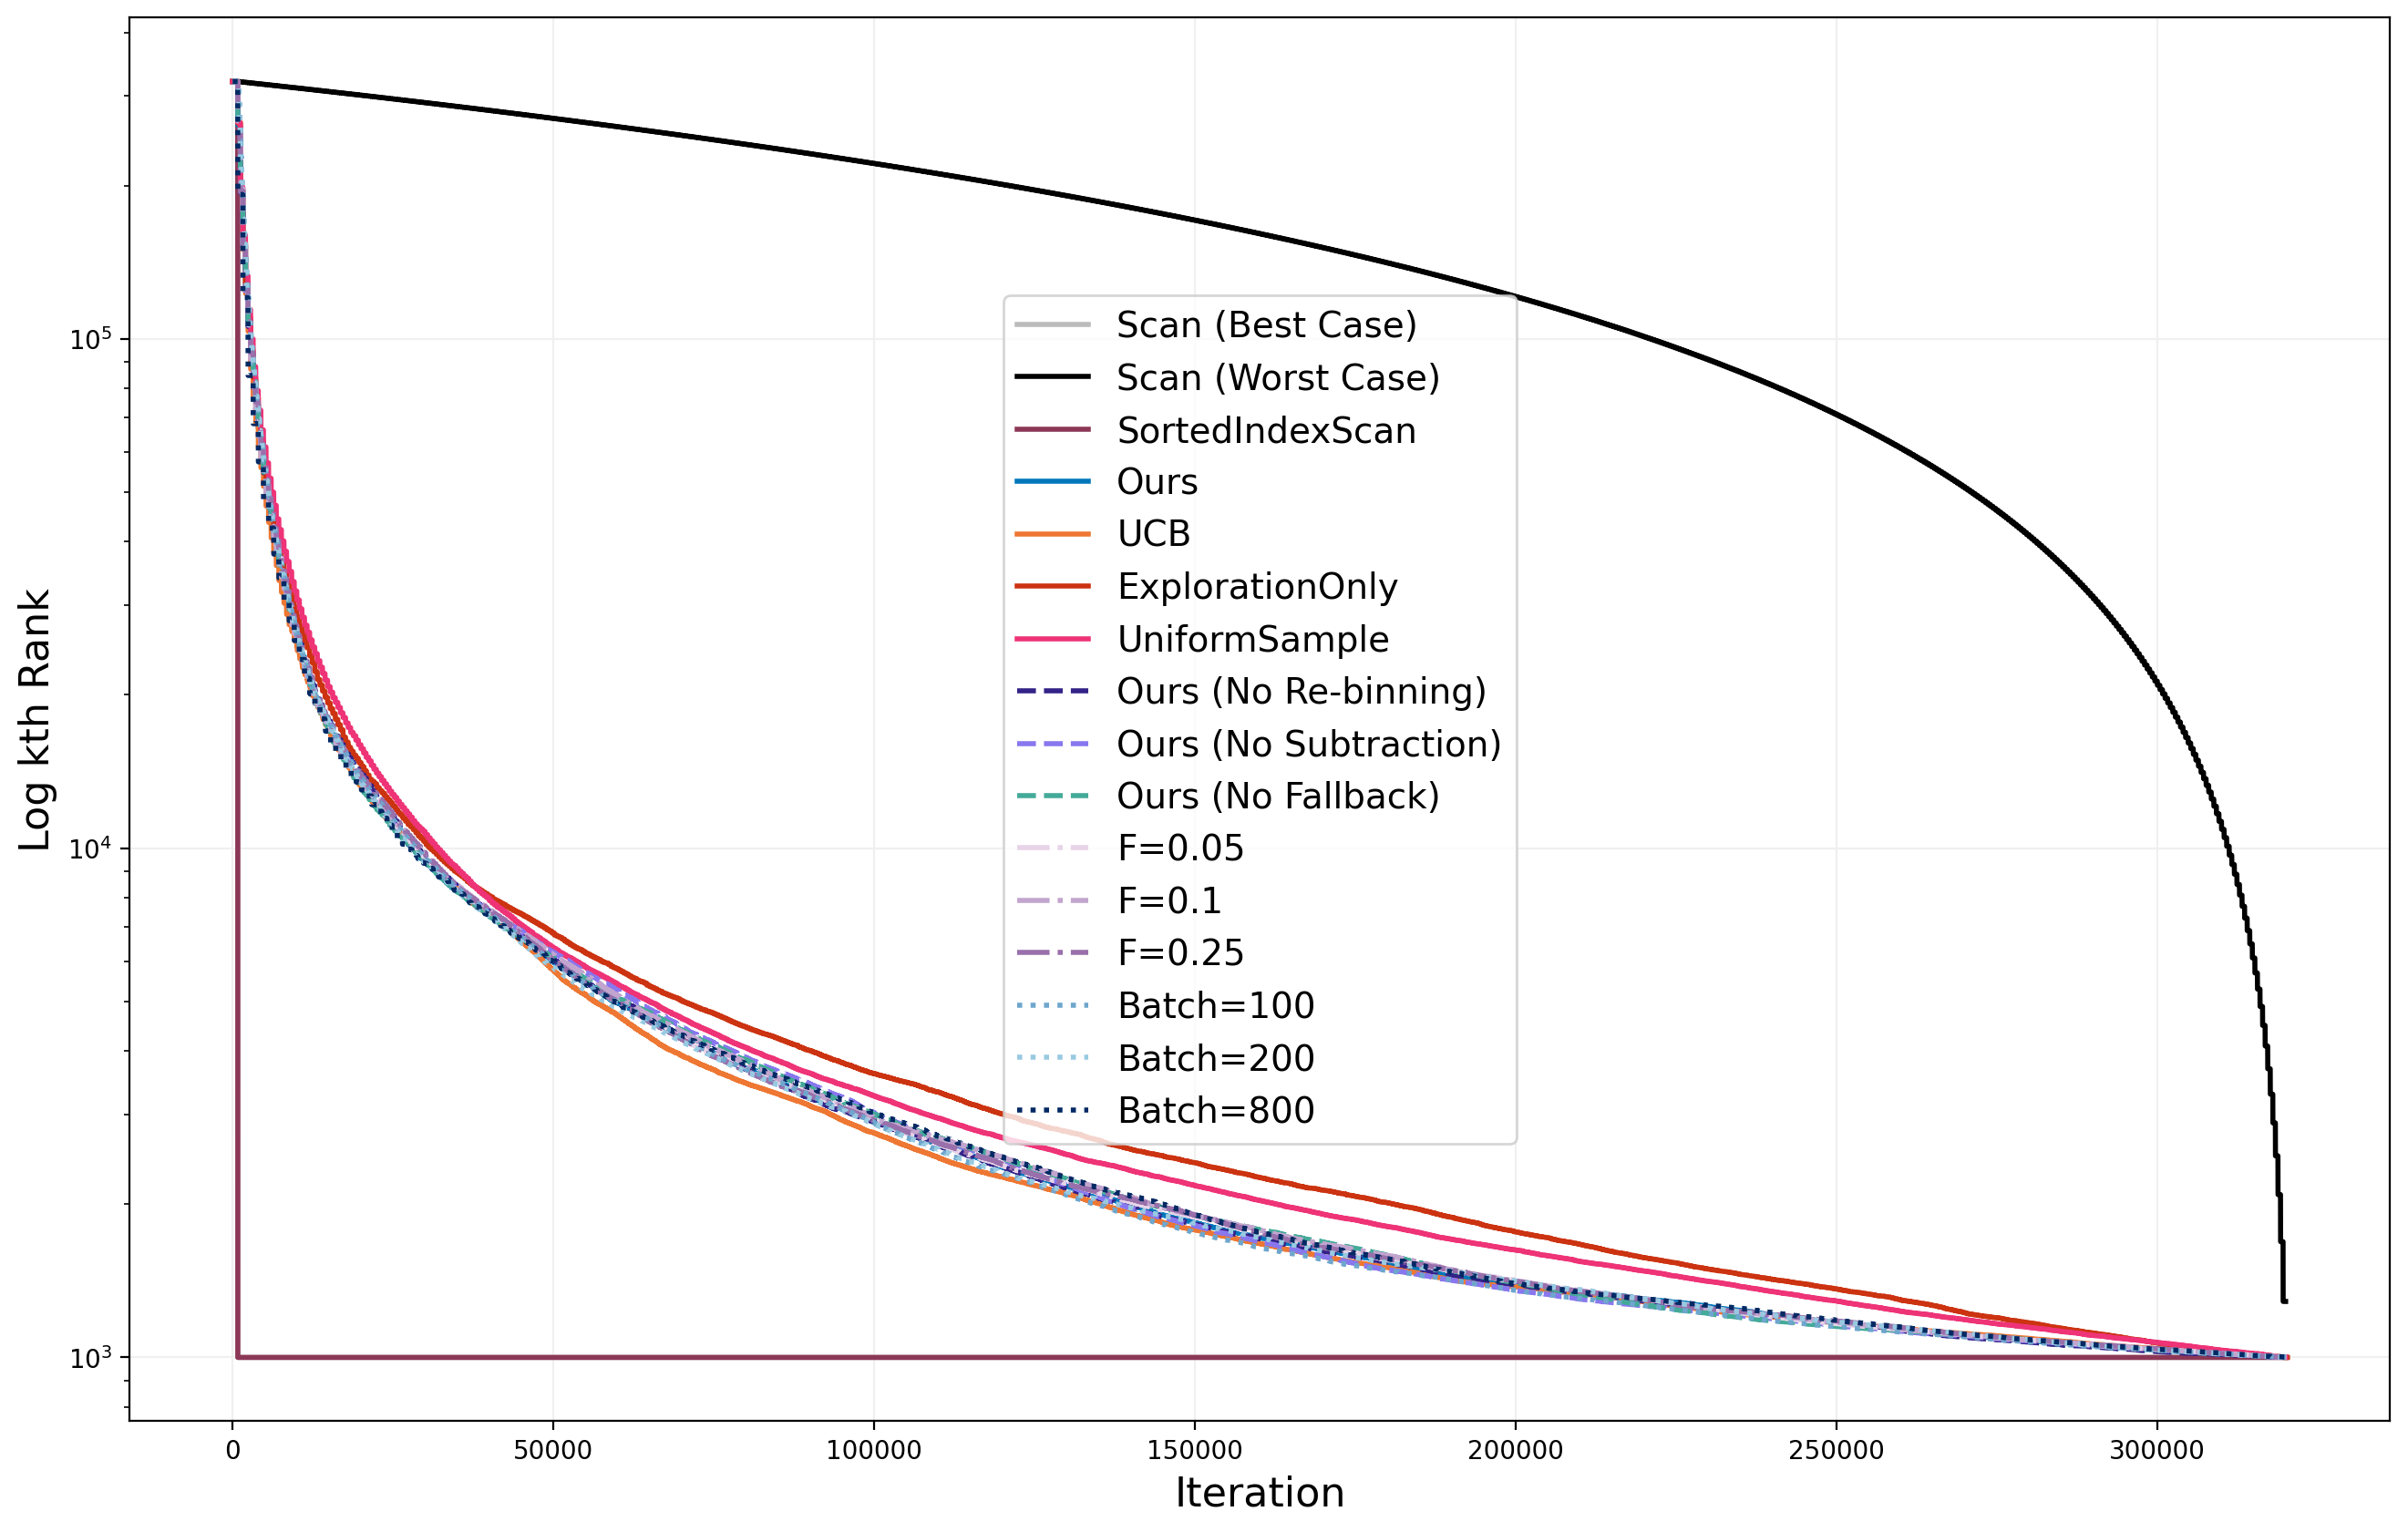

In [143]:
plot_metric_per_time_or_iter(statistics,
                             order=None,
                             metric='WorstRank',
                             x_axis='iteration',
                             y_log=True, 
                             ylabel='Log kth Rank', 
                             title=None, 
                             filename=None,
                             linewidth=2.0)

## Latency Plots

In [144]:
def plot_result_stats(result_stats: dict, 
                      order: Union[str, List[str], None], 
                      ylabel: Union[None, str] = None, 
                      xlabel: Union[None, str] = None, 
                      title: Union[None, str] = None, 
                      filename: Union[None, str] = None, 
                      time_unit: str = "s", 
                      plot_type: str = "bar", 
                      include_index_build_time: bool = False,
                      xtick_rotation: int = 20,
                      iter_colors: Union[None, List[str]] = None,
                      include_scoring_fn: bool = False,
                      fontsize: float = 18):
    """
    Plots total latency as a bar chart or per-iteration latency breakdown as a stacked bar chart.
    xtick_rotation: Angle for x-axis labels.
    iter_colors: List of colors for iteration breakdown components.
    """
    plt.figure(figsize=(16, 10))
    conversion_factor = time_units[time_unit]

    if order is None:
        order = global_order
    if isinstance(order, str):
        order = method_collections[order]
    order = [alg for alg in order if alg in result_stats]

    # Create plot data
    algorithms = order
    if plot_type == "total":  # Plot total latency of different algorithms
        latencies = [result_stats[alg]["time"][-1] * conversion_factor for alg in algorithms]

        # Include index build time if specified
        index_build_times = [
            (index_times[methods[alg]["index"]] * conversion_factor if include_index_build_time and methods[alg]["index"] else 0)
            for alg in algorithms
        ]

        plt.figure(figsize=(10, 6))
        bar_width = 0.6
        bottoms = np.zeros(len(algorithms))

        # Stacked bar chart for index build time and algorithm runtime
        for i, alg in enumerate(algorithms):
            # Plot index building times
            plt.bar(i, index_build_times[i], bar_width, color="none", edgecolor=methods[alg]["color"], linewidth=2.0, label="Index build time" if i == 0 else None)
            # Plot algorithm runtimes
            plt.bar(i, latencies[i], bar_width, facecolor=methods[alg]["color"], alpha=0.5, edgecolor=methods[alg]["color"], linewidth=2.0, bottom=index_build_times[i], label="Algorithm runtime" if i == 0 else None)

        # Add labels
        def wrap_label(text, max_width):
            from textwrap import wrap
            return "\n".join(wrap(text, max_width))

        labels = [methods[alg]["name"] for alg in algorithms]
        plt.xticks(range(len(algorithms)), labels, rotation=xtick_rotation, fontsize=fontsize, ha='right')
        plt.ylabel(ylabel if ylabel else f"End-to-End Latency ({time_unit})", fontsize=fontsize)
        plt.xlabel(xlabel if xlabel else "", fontsize=fontsize)
        plt.title(title if title else "", fontsize=fontsize)
        legend_handles = [
            plt.Rectangle((0, 0), 1, 1, facecolor="none", edgecolor="black", linewidth=2.0, label="Index construction time"),
            plt.Rectangle((0, 0), 1, 1, facecolor="gray", alpha=0.3, edgecolor="black", linewidth=2.0, label="Exhaustive algorithm runtime")
        ]
        plt.legend(handles=legend_handles, fontsize=fontsize, loc='center right')  # Optionally change loc

    elif plot_type == "iter":
        # Stacked bar chart: Breakdown of latencies
        categories = ["overhead_algo", "overhead_pq","overhead_other"] if not include_scoring_fn else ["overhead_algo", "overhead_pq","overhead_other", "overhead_scorer"]
        labels = ["Algorithm logic", "Priority queue", "Other"] if not include_scoring_fn else ["Algorithm logic", "Priority queue", "Other", "Scoring function"]

        # Use default colors if not provided
        if iter_colors is None:
            iter_colors = ["#DDAA33", "#BB5566", "#000000"] if not include_scoring_fn else ["#DDAA33", "#BB5566", "#000000", "#004488"]

        breakdowns = {alg: [result_stats[alg][cat] * conversion_factor for cat in categories] for alg in algorithms}

        plt.figure(figsize=(10, 6))
        bar_width = 0.6
        bottoms = np.zeros(len(algorithms))

        for i, (label, cat) in enumerate(zip(labels, categories)):
            heights = [breakdowns[alg][i] for alg in algorithms]
            plt.bar(range(len(algorithms)), heights, bar_width, bottom=bottoms, label=label, color=iter_colors[i], alpha=0.7, linewidth=1.0)
            bottoms += heights

        labels = [methods[alg]["name"] for alg in algorithms]
        plt.xticks(range(len(algorithms)), labels, rotation=xtick_rotation, fontsize=fontsize, ha='right')
        plt.ylabel(ylabel if ylabel else f"Latency Per Iteration ({time_unit})", fontsize=fontsize)
        plt.xlabel(xlabel if xlabel else "", fontsize=fontsize)
        plt.title(title if title else "", fontsize=fontsize)
        plt.legend(fontsize=fontsize)

    else:
        raise ValueError("Invalid plot_type..")

    # Save or show the plot
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()


### Total Latency

In [145]:
# UsedCars
#index_times = {
#    "sorted": 200.48,
#    "dendrogram": 9.105629444122314 # 5 k-means initializations
#}

In [146]:
# ImageNet
index_times = {
    "sorted": 3773,
    "dendrogram": 383.262
}

<Figure size 1600x1000 with 0 Axes>

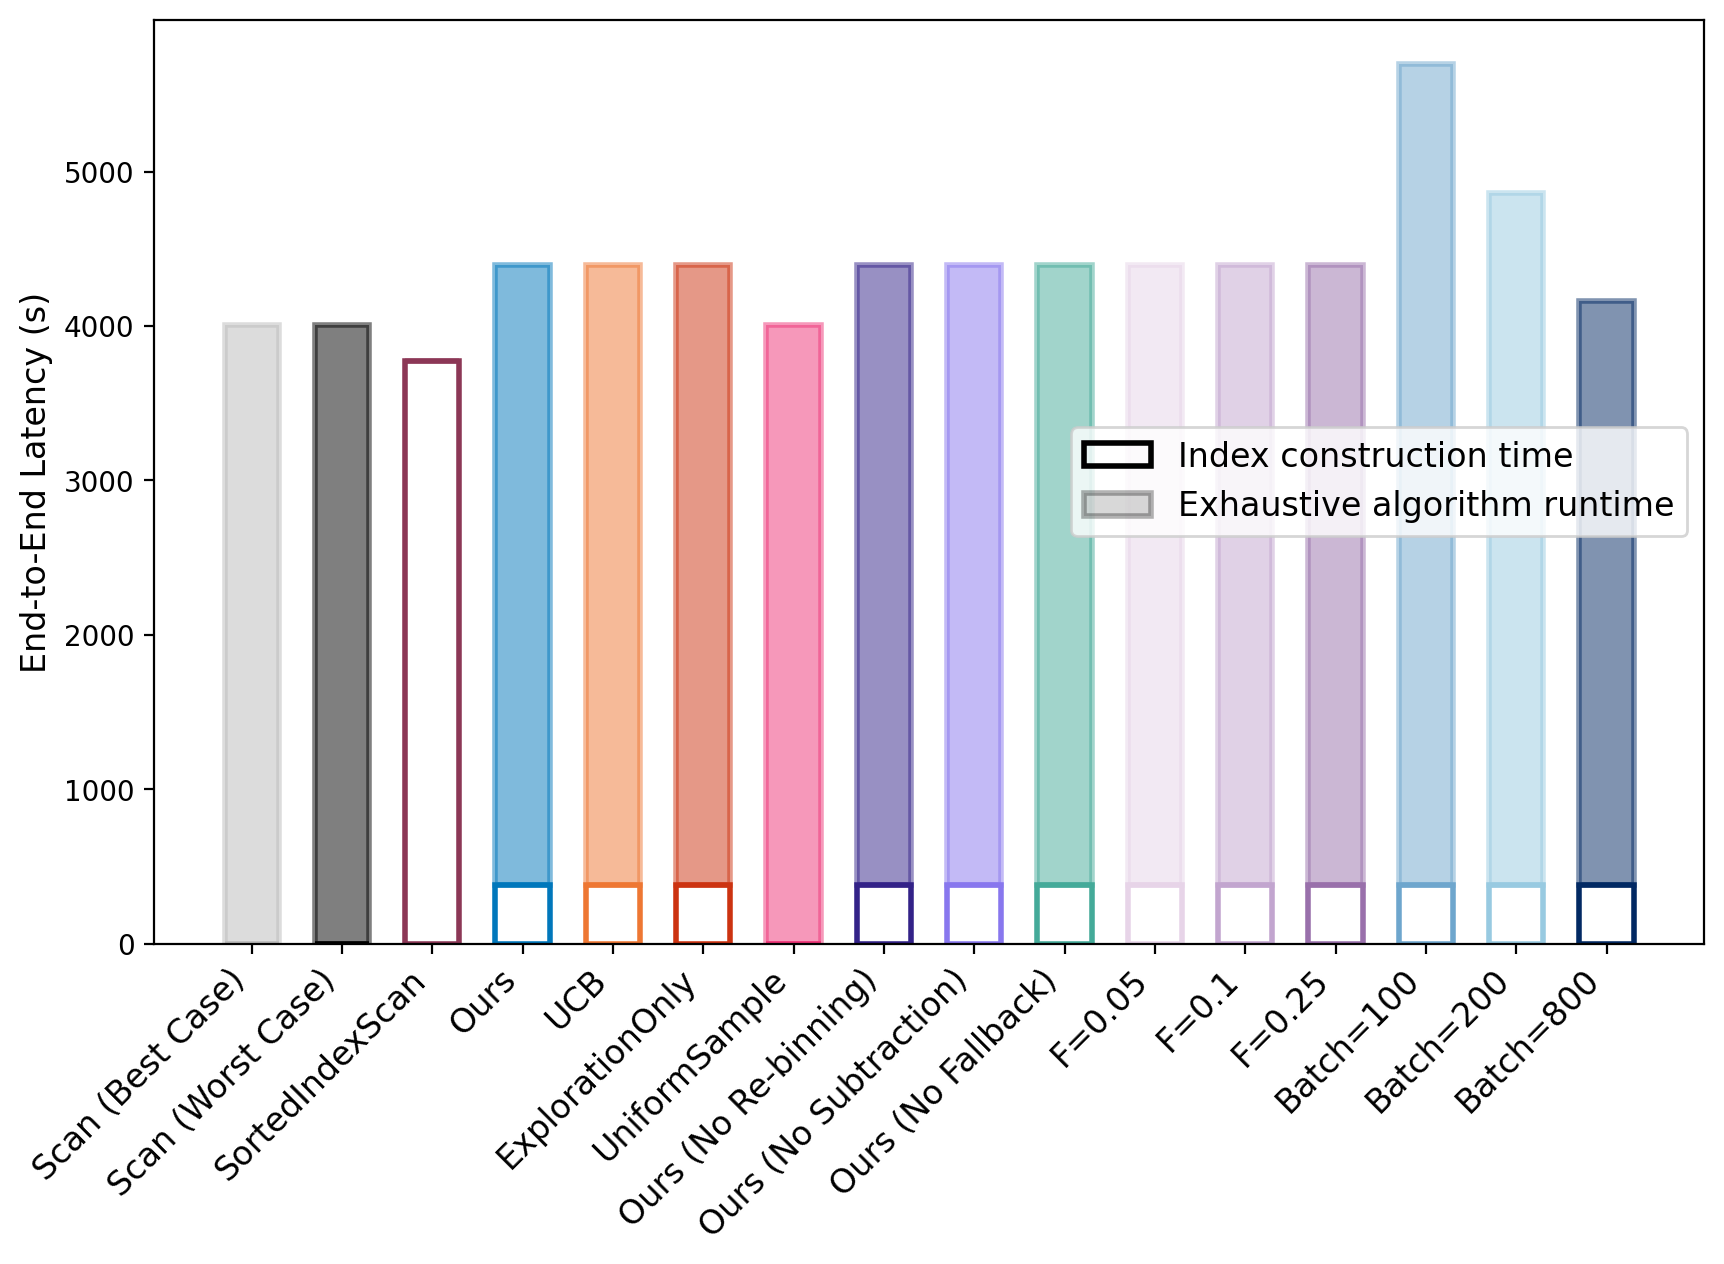

In [147]:
plot_result_stats(statistics, 
                  order=None, 
                  ylabel=None, 
                  xlabel=None, 
                  title=None, 
                  filename=None, 
                  time_unit="s", 
                  plot_type="total",
                 include_index_build_time=True,
                  fontsize=12,
                  xtick_rotation=45)

<Figure size 1600x1000 with 0 Axes>

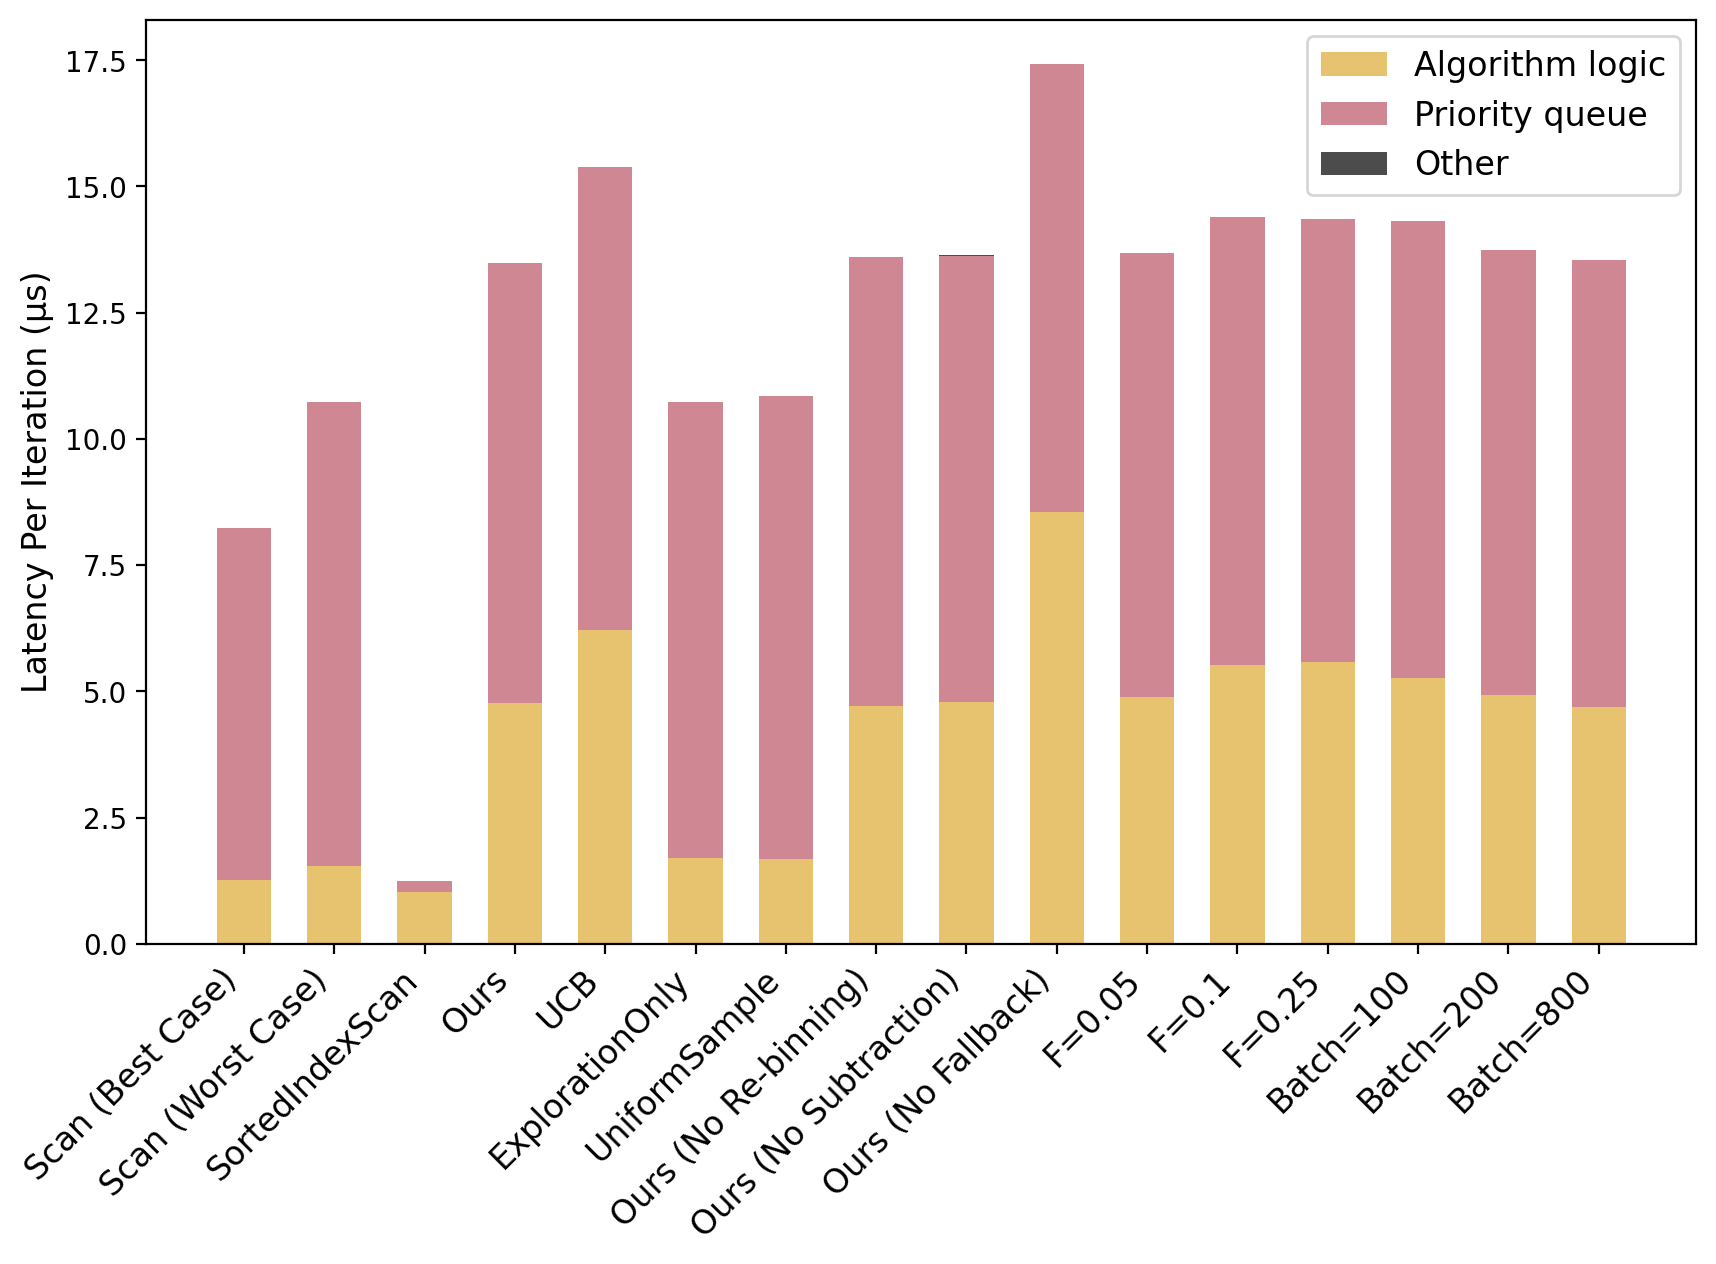

In [148]:
plot_result_stats(statistics, 
                  order=None, 
                  ylabel=None, 
                  xlabel=None, 
                  title=None, 
                  filename=None, 
                  time_unit="μs", 
                  plot_type="iter",
                  include_scoring_fn=False,
                  fontsize=12,
                  xtick_rotation=45)

<Figure size 1600x1000 with 0 Axes>

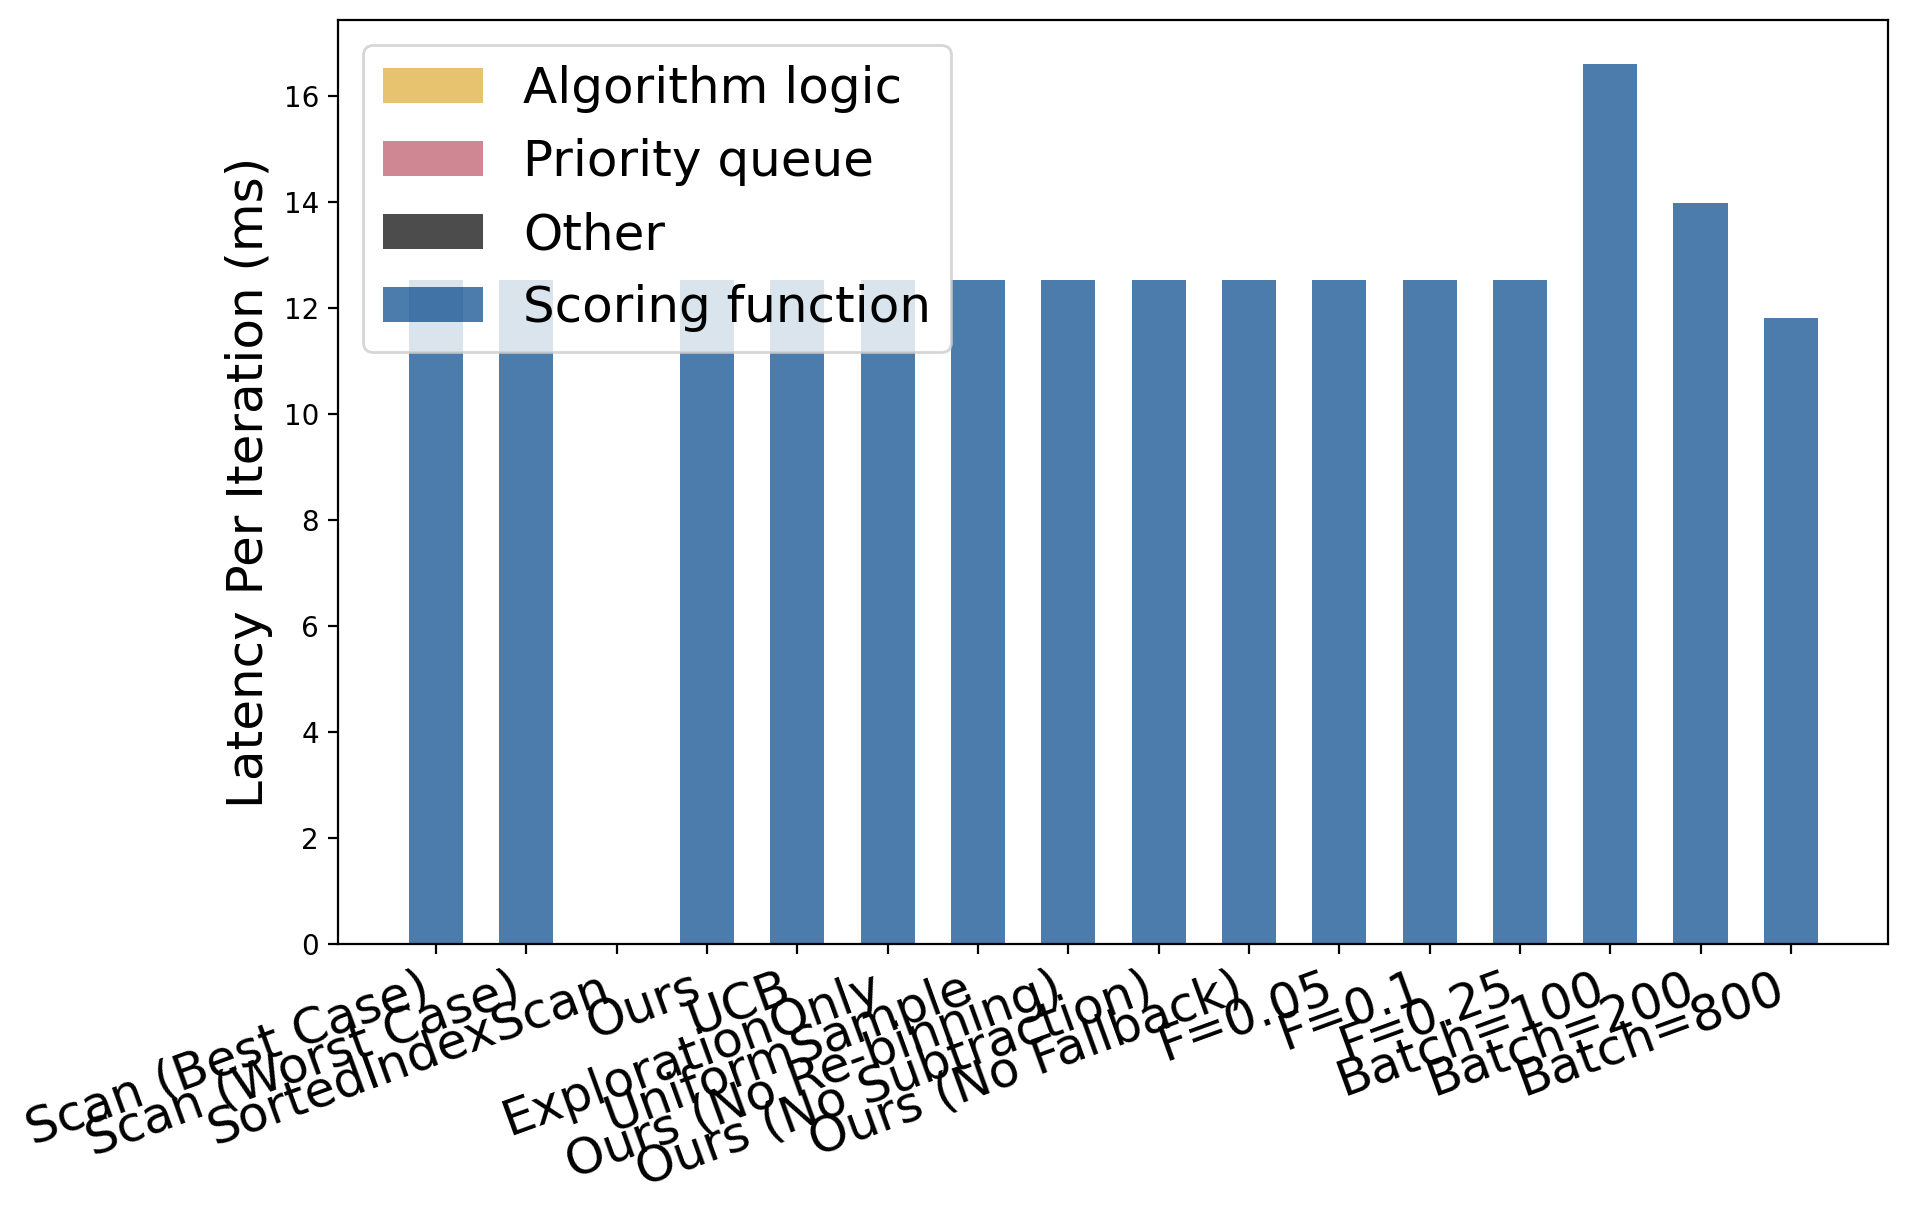

In [149]:
plot_result_stats(statistics, 
                  order=None, 
                  ylabel=None, 
                  xlabel=None, 
                  title=None, 
                  filename=None, 
                  time_unit="ms", 
                  plot_type="iter",
                  include_scoring_fn=True)